In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [4]:
df = pd.read_csv(path.join(getenv('PATH_TO_DATA'), 'bike.csv'))
df.index = df.Date
df = df.drop(['Date'], axis=1)

In [633]:
df.shape

(52584, 5)

In [634]:
df.describe()

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
count,50249.000000,50249.000000,50249.000000,50249.000000,50249.000000
mean,73.948158,20.321857,9.827698,21.846106,21.952497
std,191.864307,135.919922,41.630237,33.290811,62.598346
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,1.000000,1.000000
50%,33.000000,5.000000,4.000000,8.000000,9.000000
75%,94.000000,14.000000,13.000000,30.000000,32.000000
max,10493.000000,4054.000000,4095.000000,794.000000,8191.000000


In [7]:
# Сократим датасет до 10 тысяч.
df = df[:10000]

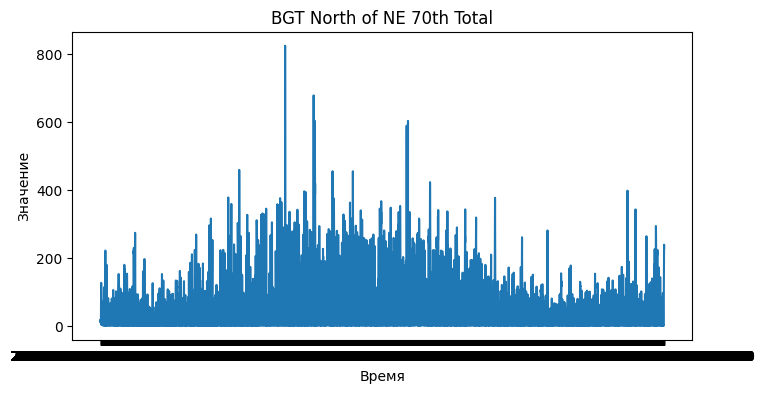

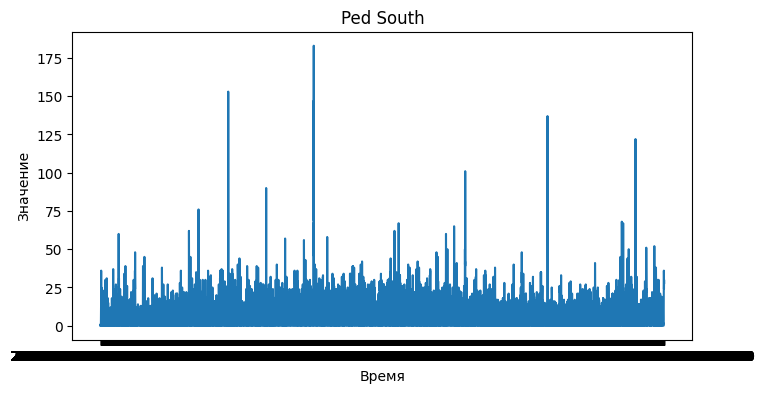

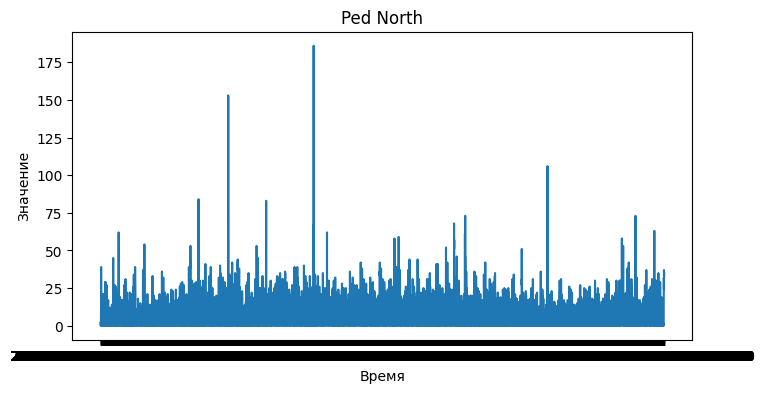

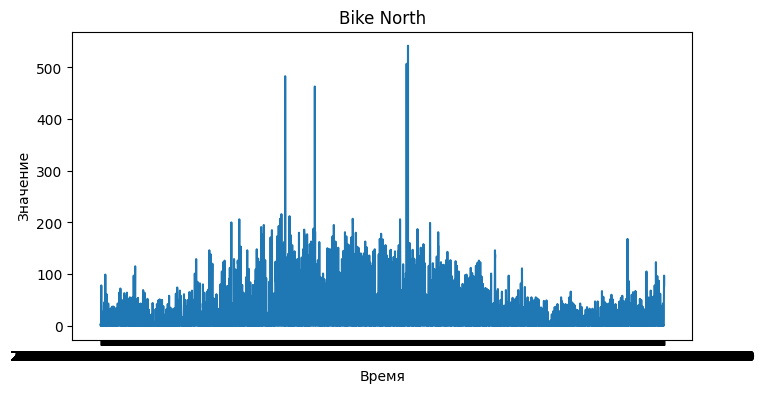

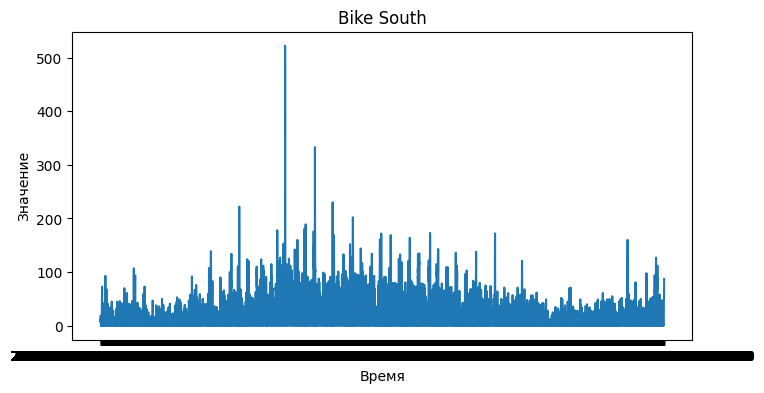

In [9]:
columns = df.columns

for column in columns:
    plt.figure(figsize=(8, 4))
    plt.plot(df[column])
    plt.title(column)
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.show()

In [471]:
df.isna().mean() 

BGT North of NE 70th Total    0.0003
Ped South                     0.0003
Ped North                     0.0003
Bike North                    0.0003
Bike South                    0.0003
dtype: float64

In [10]:
df = df.dropna()

# Проверяем стационарность

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [12]:
train = df[:int(0.8*(len(df)))]
test = df[int(0.8*(len(df))):]

In [614]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BGT North of NE 70th Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4077
 No. Lags Chosen       = 35
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Ped South" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0446
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Ped North" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

# Видим, что все ряды стационарны. Дифференцировать не требуется. #

# Коинтеграция — свойство нескольких нестационарных временных рядов, заключающееся в существовании некоторой их стационарной линейной комбинации. #

# Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.). # 

In [13]:
# granger causality tests

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [14]:
grangers_causation_matrix(df, variables = df.columns) 

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of cons

,BGT North of NE 70th Total_x,Ped South_x,Ped North_x,Bike North_x,Bike South_x
BGT North of NE 70th Total_y,1.0,0.0,0.0,0.0,0.0
Ped South_y,0.0,1.0,0.0,0.0,0.0
Ped North_y,0.0,0.0,1.0,0.0,0.0
Bike North_y,0.0,0.0,0.0,1.0,0.0
Bike South_y,0.0,0.0,0.0,0.0,1.0


# Видим, что почти все p-значения < 0.05. Мы можем сделать вывод о том, что существует причинная связь между рядами. Значит, можем использовать VAR-модель для предсказания #

# Давайте подберем оптимальный порядок модели.

In [15]:
# Чтобы выбрать правильный порядок модели VAR, мы итеративно подбираем возрастающие порядки модели VAR и выбираем порядок, который дает модель с наименьшим AIC.

from statsmodels.tsa.vector_ar.var_model import VAR


model = VAR(df)
for i in [2, 3, 10, 11, 12, 13, 14, 15, 20, 21, 23, 30, 35]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 2
AIC :  4.569790779128601
BIC :  4.60946473746591
FPE :  96.52391327184057
HQIC:  4.583220491534382 

Lag Order = 3
AIC :  5.752086299575571
BIC :  5.809798848640242
FPE :  314.8468446894781
HQIC:  5.771622207368586 

Lag Order = 10
AIC :  7.659160563986601
BIC :  7.843230362644056
FPE :  2119.978037393828
HQIC:  7.721471031095804 

Lag Order = 11
AIC :  8.172127129905975
BIC :  8.374260419461049
FPE :  3540.8699260817975
HQIC:  8.240552708088186 

Lag Order = 12
AIC :  4.424479479605053
BIC :  4.6446793764487415
FPE :  83.46941185389804
HQIC:  4.499021284746336 

Lag Order = 13
AIC :  7.9555870271210045
BIC :  8.193856648505323
FPE :  2851.4644690610053
HQIC:  8.03624617542457 

Lag Order = 14
AIC :  7.597512030146327
BIC :  7.8538544941846355
FPE :  1993.2330134803035
HQIC:  7.684289638132657 

Lag Order = 15
AIC :  7.426138580975604
BIC :  7.700557006642929
FPE :  1679.3129865964315
HQIC:  7.519035765482572 

Lag Order = 20
AIC :  6.401935239766915
BIC :  6.766780288385

In [617]:
# у порядка 3 наименьший показатель AIC. Берем его.
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jan, 2024
Time:                     11:49:46
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -12.0642
Nobs:                     9994.00    HQIC:                  -12.1024
Log likelihood:          -10251.0    FPE:                5.43880e-06
AIC:                     -12.1220    Det(Omega_mle):     8.97805e-07
--------------------------------------------------------------------
Results for equation BGT North of NE 70th Total
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 7.734401         0.398883           19.390           0.000
L1.BGT North of NE 70th Total         0.945265    944758.941357         

In [618]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [619]:
X_test, Y_test = create_test_dataset(test, 336)
X_train, Y_train = create_train_dataset(train, 336)

In [620]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [621]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)


In [622]:
def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3
    ) 

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true,pred),"\n") 

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]
        
        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
        validate(name, Y_true, Y_pred)

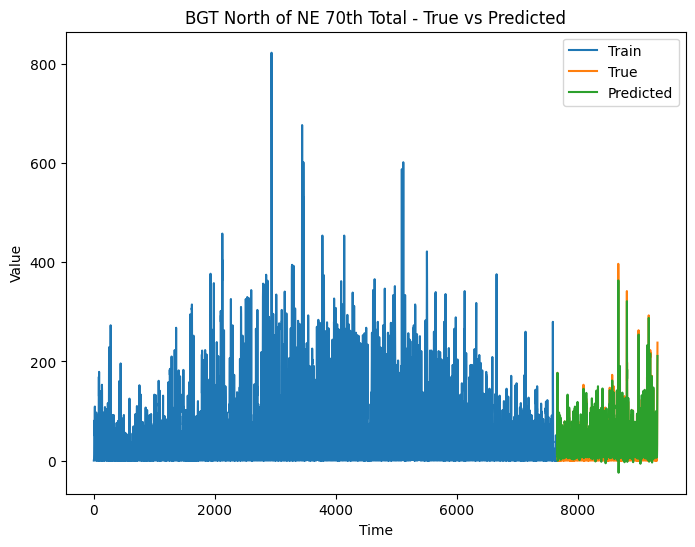

Метрики BGT North of NE 70th Total
MSE: 373.28024502711514
RMSE: 19.320461822304225
MAE: 13.350419345336276
SMAPE: 0.766
R2: 0.9300285883435142 



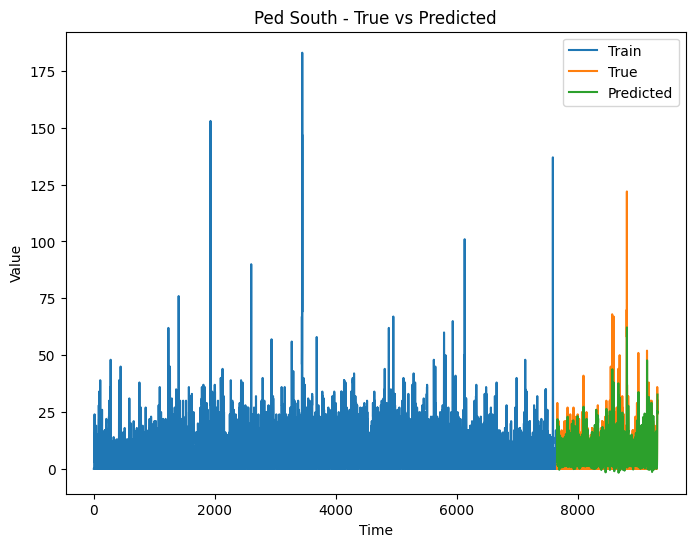

Метрики Ped South
MSE: 31.12375247841043
RMSE: 5.5788665944267235
MAE: 3.22704344426256
SMAPE: 0.922
R2: 0.9090180277185396 



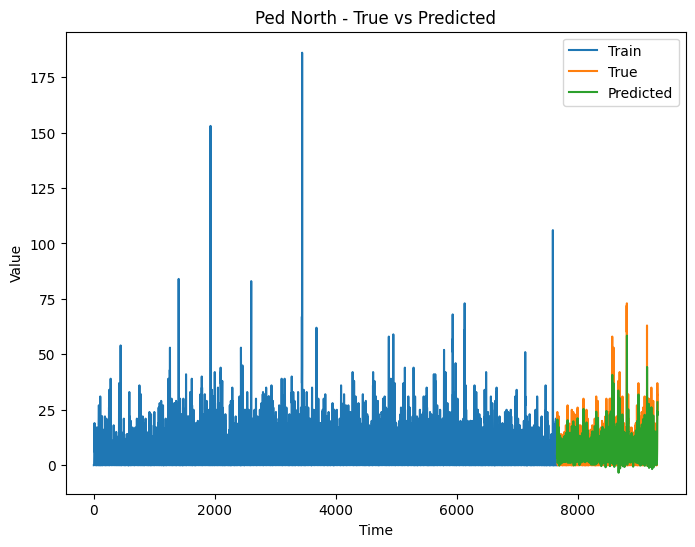

Метрики Ped North
MSE: 26.99189630734441
RMSE: 5.195372585998468
MAE: 3.3441379007632084
SMAPE: 0.966
R2: 0.9746124986118672 



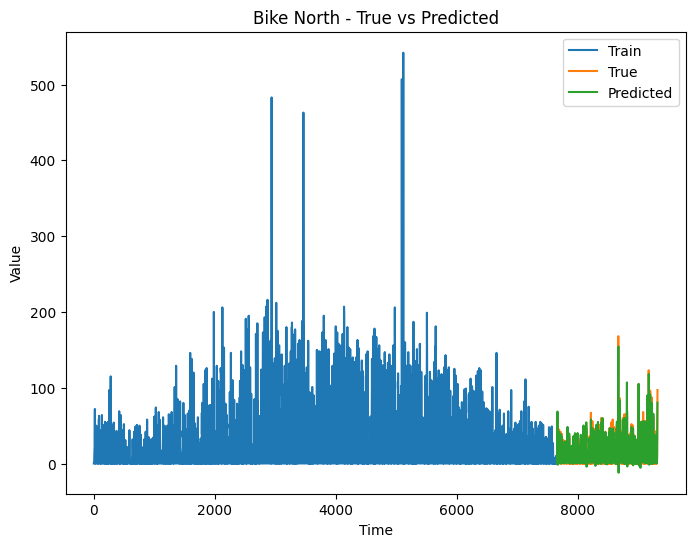

Метрики Bike North
MSE: 65.64234130160509
RMSE: 8.101996130683172
MAE: 5.229485606863069
SMAPE: 0.886
R2: 0.9622941753733609 



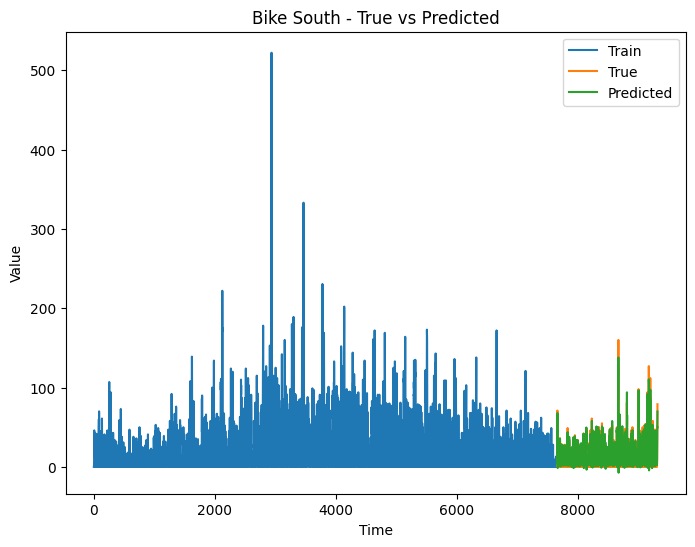

Метрики Bike South
MSE: 64.22732240099552
RMSE: 8.014195056335696
MAE: 5.4404220199475235
SMAPE: 0.923
R2: 0.9405318473266371 



In [623]:
plot_and_metrics(df.columns, Y_test, Y_pred, Y_train)

# Теперь используем модель VARMA #

In [17]:
train, test = df[:int(0.8 * df.shape[0])], df[int(0.8 * df.shape[0]):] 

In [18]:
from pmdarima import auto_arima

pq = []
for name, column in df.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : BGT North of NE 70th Total
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=97088.699, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98368.670, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=97101.784, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97188.149, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98366.674, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=97060.897, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=97059.718, Time=0.74 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=97060.314, Time=1.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=97057.720, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=97186.151, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=97058.899, Time=0.64 sec
 ARIMA(0,1,3)(0,0,0)[0]             : 

In [19]:
pq

[(0, 1, 2), (1, 1, 0), (1, 1, 1), (0, 1, 4), (0, 1, 4)]

In [24]:
df.corr()

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
BGT North of NE 70th Total,1.000000,0.795367,0.777795,0.934391,0.927143
Ped South,0.795367,1.000000,0.910463,0.612083,0.674967
Ped North,0.777795,0.910463,1.000000,0.620353,0.622082
Bike North,0.934391,0.612083,0.620353,1.000000,0.793389
Bike South,0.927143,0.674967,0.622082,0.793389,1.000000


In [20]:
df_copy = df.drop(df.columns[-1], axis=1) # т.к. VARMA не работал из-за слишком сильной корреляции последнего столбца с остальными, было принято решение его удалить для обучения этой модели

In [21]:
train = df_copy[:400]
test = df_copy[400:]

In [22]:
df_copy = df_copy[:500] # уменьшим выборку до 500 элементов в силу экономии времени

In [23]:
from statsmodels.tsa.statespace.varmax import VARMAX

df_results_moni = pd.DataFrame(columns=['p', 'q'] + list(df.columns))
for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        total = np.sqrt(metrics.mean_squared_error(test['BGT North of NE 70th Total'], result['BGT North of NE 70th Total']))
        ped_south = np.sqrt(metrics.mean_squared_error(test['Ped South'], result['Ped South']))
        ped_north = np.sqrt(metrics.mean_squared_error(test['Ped North'], result['Ped North']))
        bike_north = np.sqrt(metrics.mean_squared_error(test['Bike North'], result['Bike North']))

        new_row = {'p': i[0], 'q': i[2], 'BGT North of NE 70th Total': total,'Ped South': ped_south,'Ped South': ped_north,
                   'Bike North' : bike_north}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/ns/8k4fm20x1_g6s3_88nzjddf00000gn/T/ipykernel_27225/413952320.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_ind

In [96]:
df_results_moni.sort_values(by=['BGT North of NE 70th Total', 'Ped South', 'Bike North']) # наилучшие p, q - 1, 1

,p,q,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
3,0,4,52.020261,8.910196,NaN,19.282954,NaN
4,0,4,52.020261,8.910196,NaN,19.282954,NaN
0,0,2,52.041714,8.919685,NaN,19.300330,NaN
1,1,0,52.184162,8.954371,NaN,19.273532,NaN
2,1,1,52.647729,8.956518,NaN,19.539457,NaN


In [24]:
model = VARMAX(train, order=(1,1)).fit(disp=False)
result = model.forecast(steps=len(test))

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [99]:
df_copy.columns

Index(['BGT North of NE 70th Total', 'Ped South', 'Ped North', 'Bike North'], dtype='object')

In [100]:
test.shape

(100, 4)

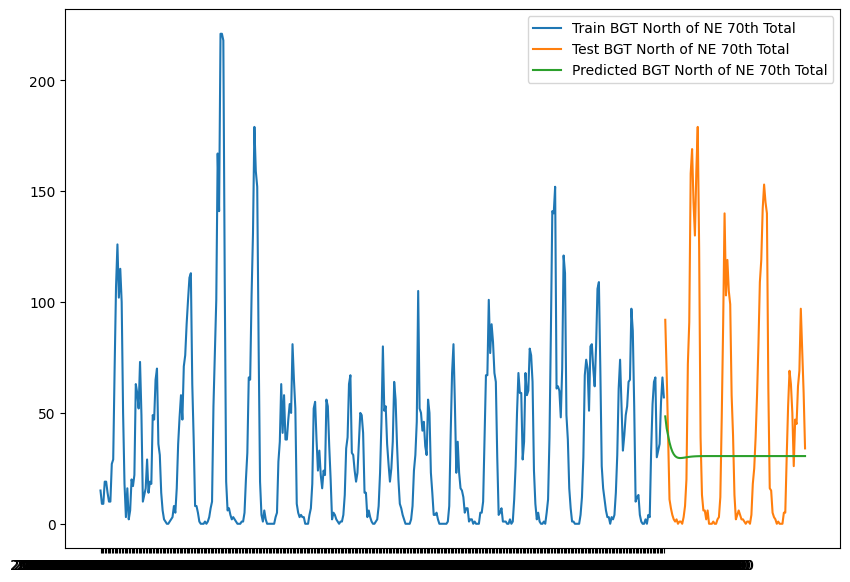

Evaluation metric for BGT North of NE 70th Total
MSE: 2771.783371272179
MAE: 40.746521502013714
RMSE: 52.64772902293297
SMAPE: nan
R2: 0.9096333464503747



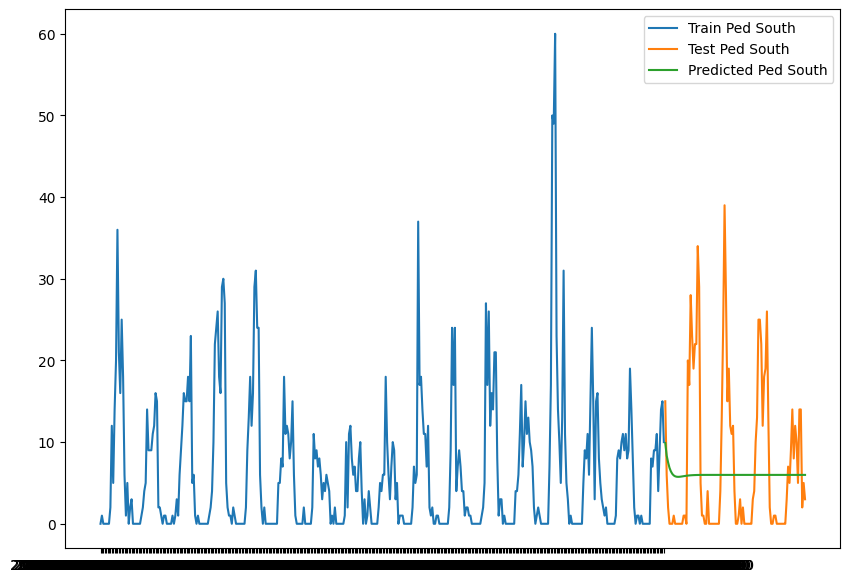

Evaluation metric for Ped South
MSE: 92.22369735889832
MAE: 7.586030354327761
RMSE: 9.603316997730436
SMAPE: nan
R2: 0.9020930928289903



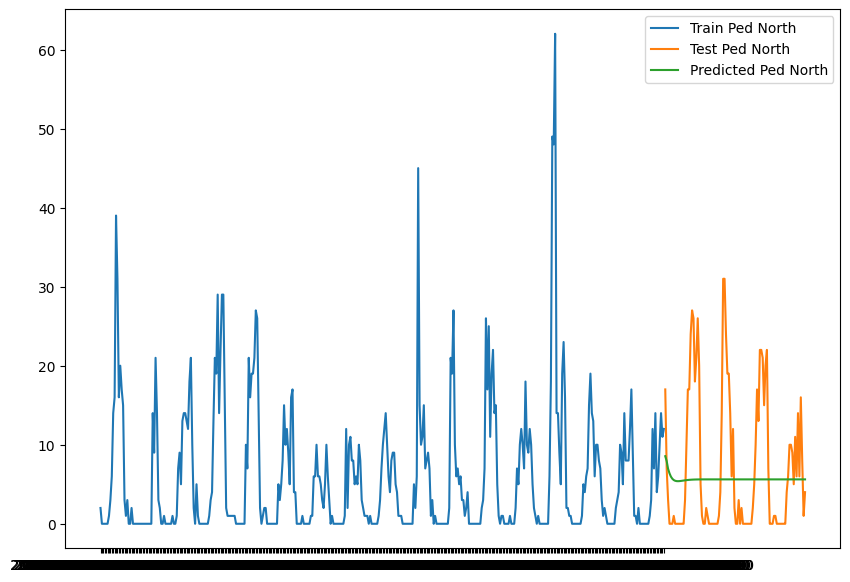

Evaluation metric for Ped North
MSE: 80.21921018386016
MAE: 7.130606206246687
RMSE: 8.956517748760405
SMAPE: nan
R2: 0.9914668486698386



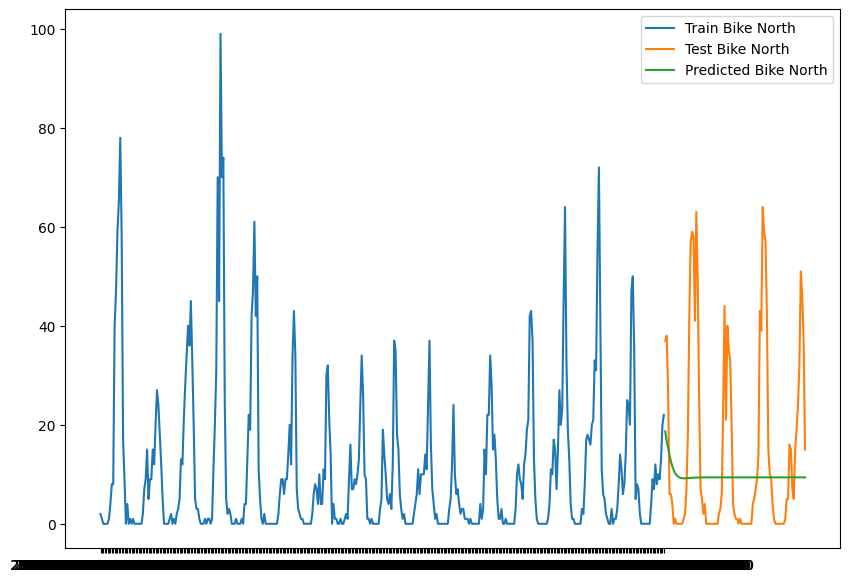

Evaluation metric for Bike North
MSE: 381.7903970628891
MAE: 14.303323333917717
RMSE: 19.53945744034079
SMAPE: nan
R2: 0.9424047138195256



In [106]:
for i in df_copy.columns:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(400, 500), test[str(i)], label='Test '+str(i))
    plt.plot(range(400, 500), result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , result[str(i)])

# Нейросети #

In [639]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from itertools import combinations
from statsmodels.tsa.stattools import coint, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from tensorflow import keras
from keras import Input, Model
from tcn import TCN

In [649]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from keras import Input, Model
from sklearn.model_selection import GridSearchCV
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv(r'data\bike.csv')

In [672]:
df_LSTM = pd.DataFrame(data['Date'])
df_LSTM['BGT North of NE 70th Total'] = data['BGT North of NE 70th Total']
df_LSTM['Ped South'] = data['Ped South']
df_LSTM['Ped North'] = data['Ped North']
df_LSTM['Bike North'] = data['Bike North']
df_LSTM['Bike South'] = data['Bike South']

df_LSTM.set_index('Date', inplace=True)

df_LSTM.dropna(inplace=True)

lookback_window = 1

df_LSTM = df_LSTM.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_LSTM[i - lookback_window:i])
    y.append(df_LSTM[i])
x = np.array(x)
y = np.array(y)

In [673]:
x_train = x[0:42000]
y_train = y[0:42000]
x_test = x[42000:]
y_test = y[42000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 5)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 5)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 5)).reshape(x_test.shape)

In [674]:
i = Input(shape=(lookback_window, 5))
m = LSTM(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(5, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 5)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 90)                34560     
                                                                 
 dense_8 (Dense)             (None, 5)                 455       
                                                                 
Total params: 35015 (136.78 KB)
Trainable params: 35015 (136.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [675]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

In [676]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 5)).reshape(y_pred_scaled.shape)

258/258 [==============================] - 2s 4ms/step


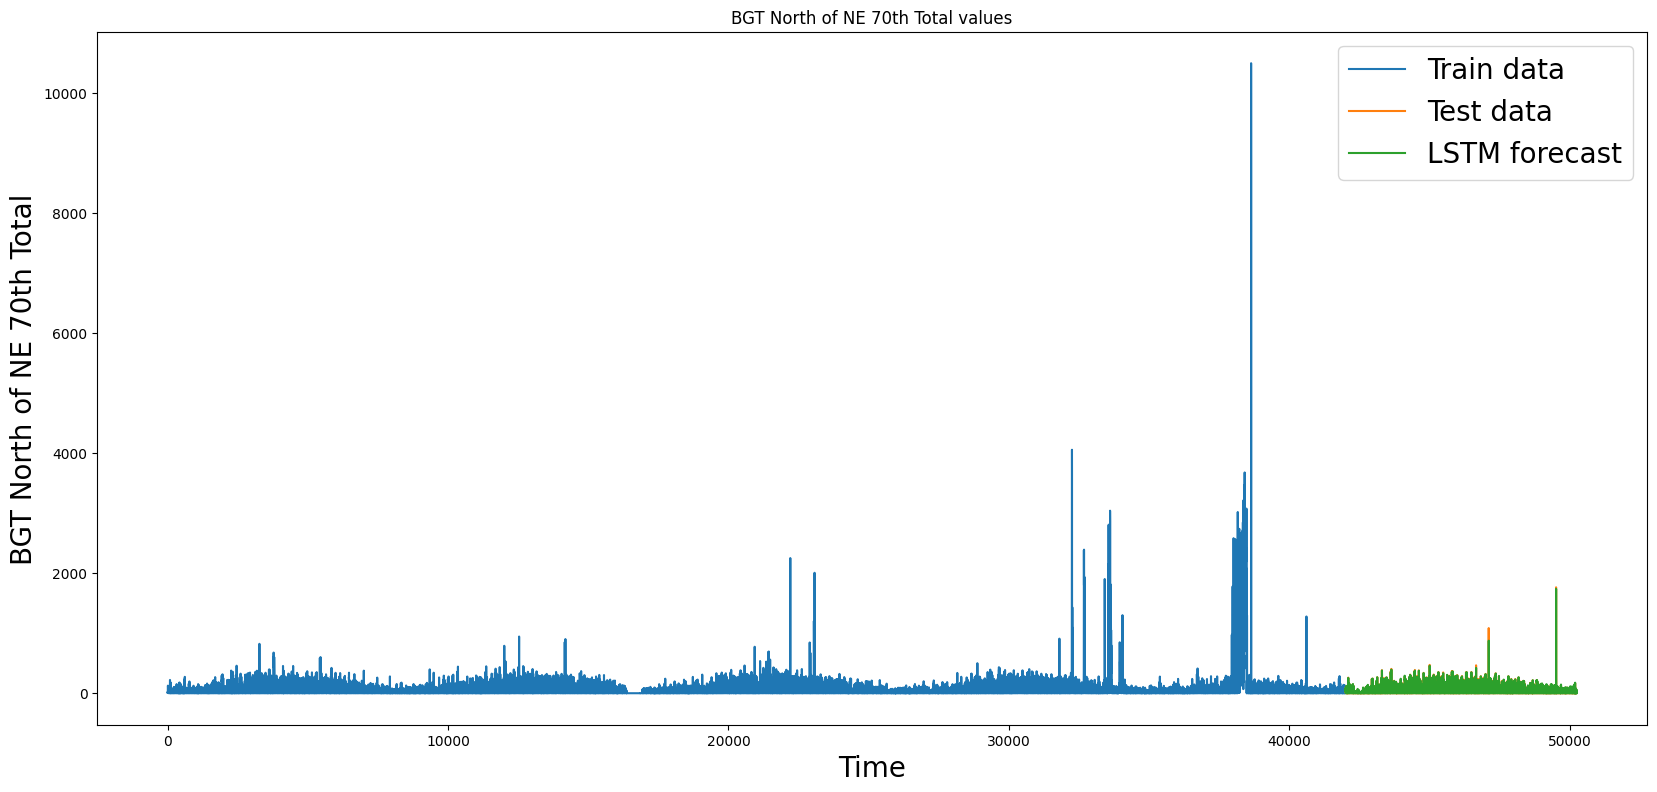

LSTM Metrics BGT North of NE 70th Total:
RMSE: 39.59099530305349
MSE: 1567.4469090864034
SMAPE: 0.201
MAE: 19.409447401935445
R^2: 0.9125198245494868


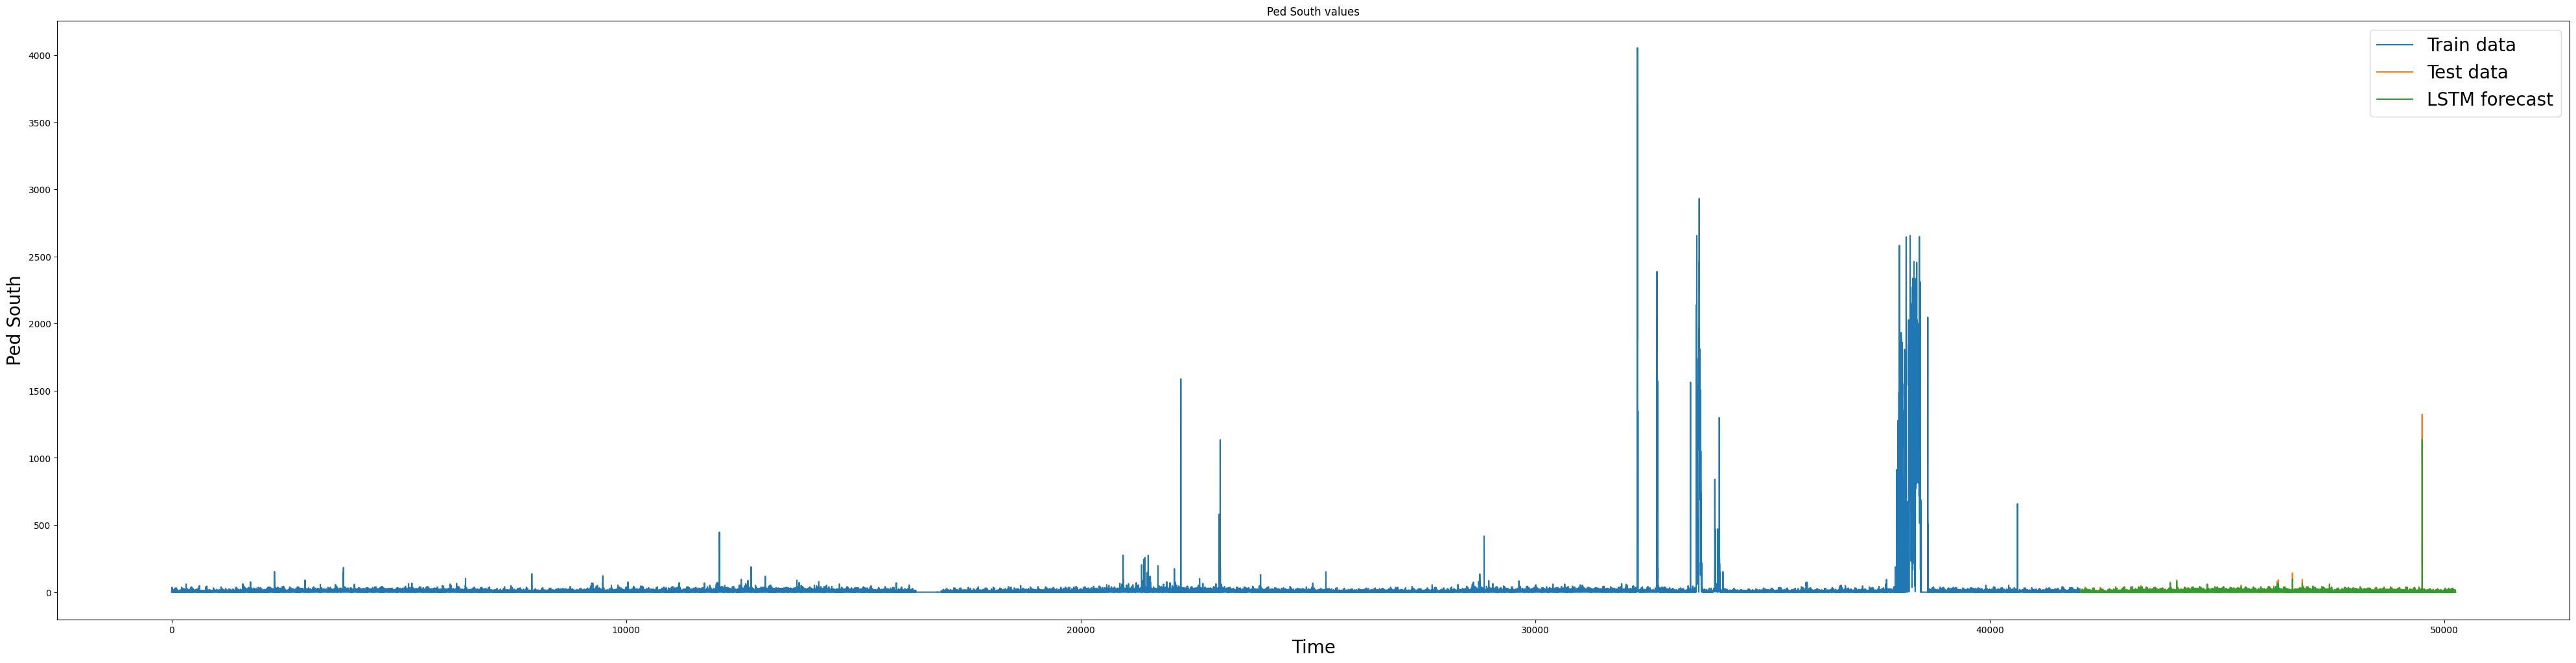

LSTM Metrics Ped South:
RMSE: 19.05159963606744
MSE: 362.963448693005
SMAPE: 0.263
MAE: 3.8508874543667675
R^2: 0.9063841401730125


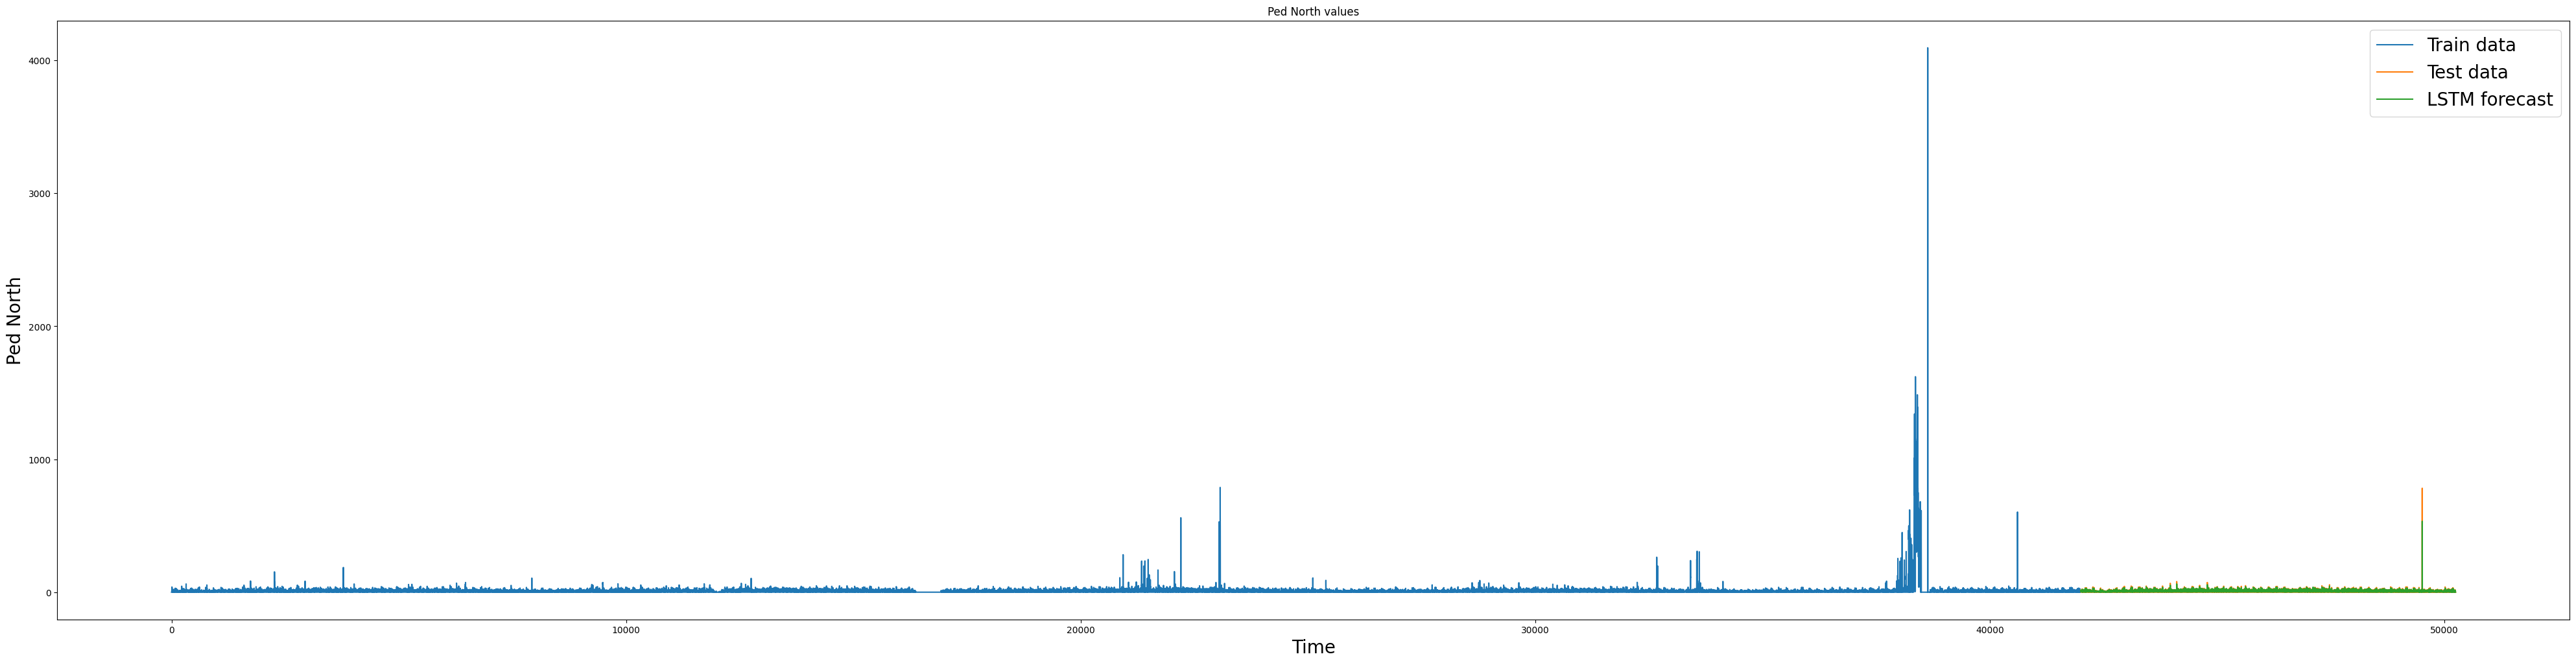

LSTM Metrics Ped North:
RMSE: 9.481225376549519
MSE: 89.89363464092656
SMAPE: 0.229
MAE: 3.8723169814372502
R^2: 0.9102563073393519


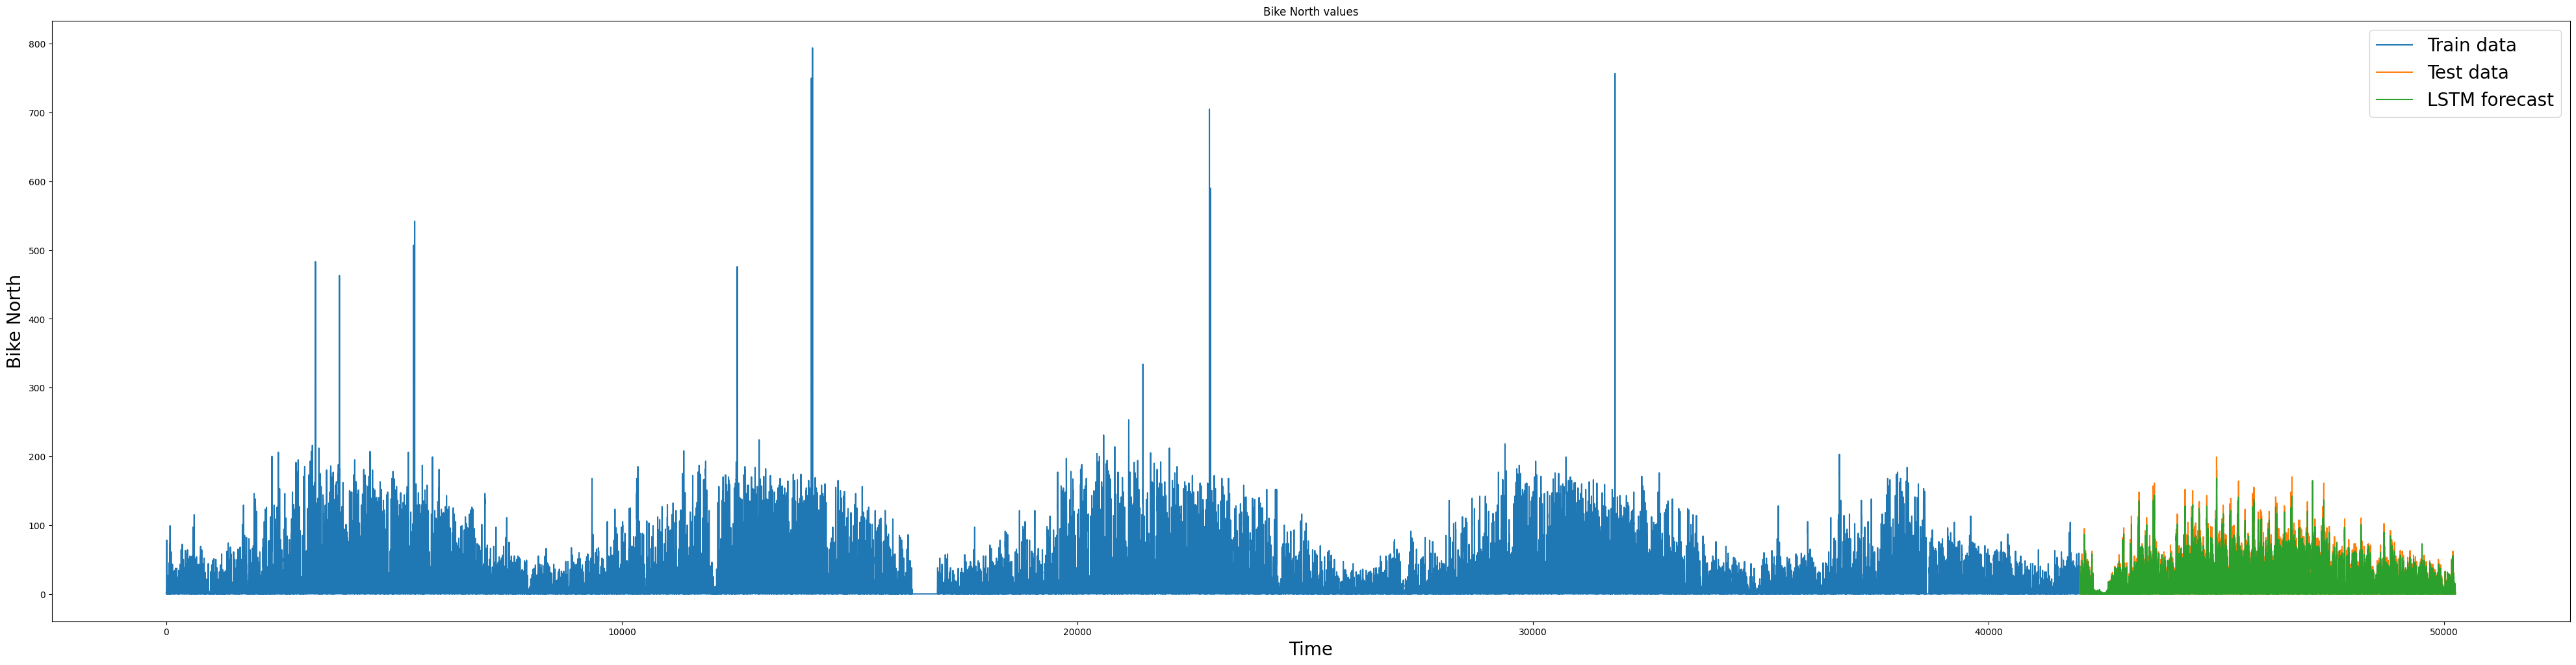

LSTM Metrics Bike North:
RMSE: 12.359443580417523
MSE: 152.75584561752393
SMAPE: 0.248
MAE: 7.732247855388726
R^2: 0.9553518508213665


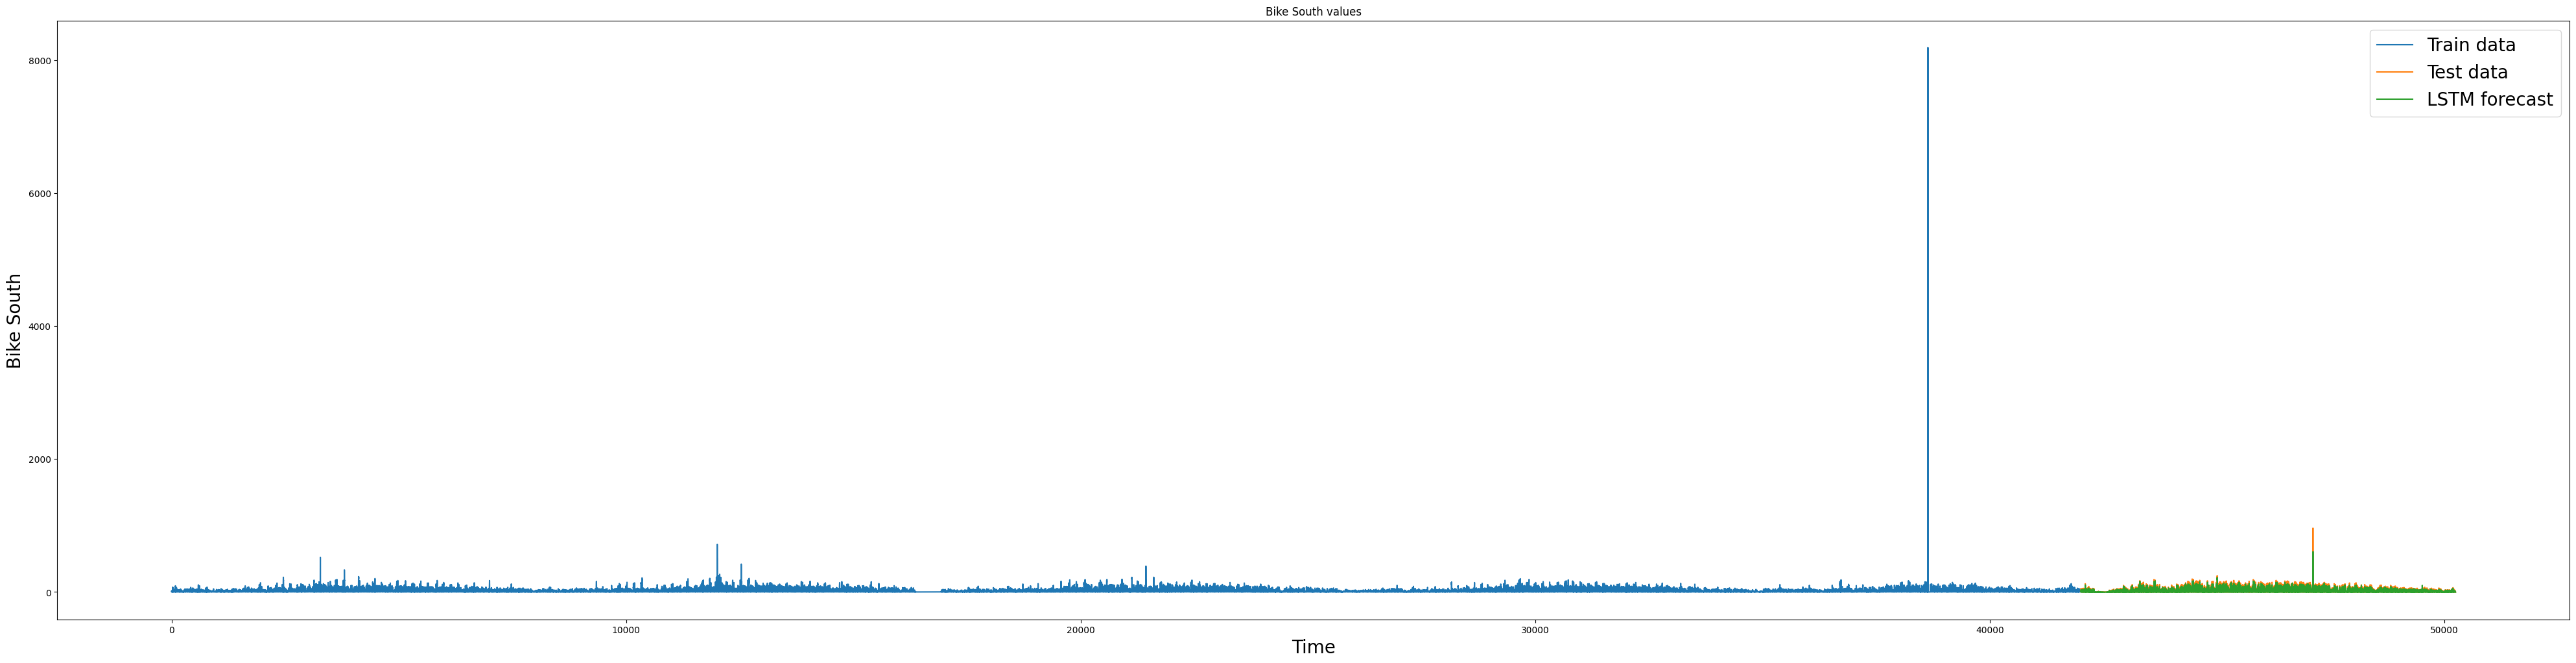

LSTM Metrics Bike South:
RMSE: 19.037690400042152
MSE: 362.4336557678571
SMAPE: 0.273
MAE: 9.67948895101696
R^2: 0.914954332673461


In [678]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = df.columns

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col) ) 

In [679]:
df_GRU = pd.DataFrame(data['Date'])
df_GRU['BGT North of NE 70th Total'] = data['BGT North of NE 70th Total']
df_GRU['Ped South'] = data['Ped South']
df_GRU['Ped North'] = data['Ped North']
df_GRU['Bike North'] = data['Bike North']
df_GRU['Bike South'] = data['Bike South']
df_GRU.set_index('Date', inplace=True)

df_GRU.dropna(inplace=True)
lookback_window = 1

df_GRU = df_GRU.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_GRU[i - lookback_window:i])
    y.append(df_GRU[i])
x = np.array(x)
y = np.array(y)

In [681]:
x_train = x[0:42000]
y_train = y[0:42000]
x_test = x[42000:]
y_test = y[42000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 5)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 5)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 5)).reshape(x_test.shape)


In [684]:
i = Input(shape=(lookback_window, 5))
m = GRU(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(5, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1, 5)]            0         
                                                                 
 gru_1 (GRU)                 (None, 90)                26190     
                                                                 
 dense_10 (Dense)            (None, 5)                 455       
                                                                 
Total params: 26645 (104.08 KB)
Trainable params: 26645 (104.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [685]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

In [687]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 5)).reshape(y_pred_scaled.shape)

258/258 [==============================] - 1s 4ms/step


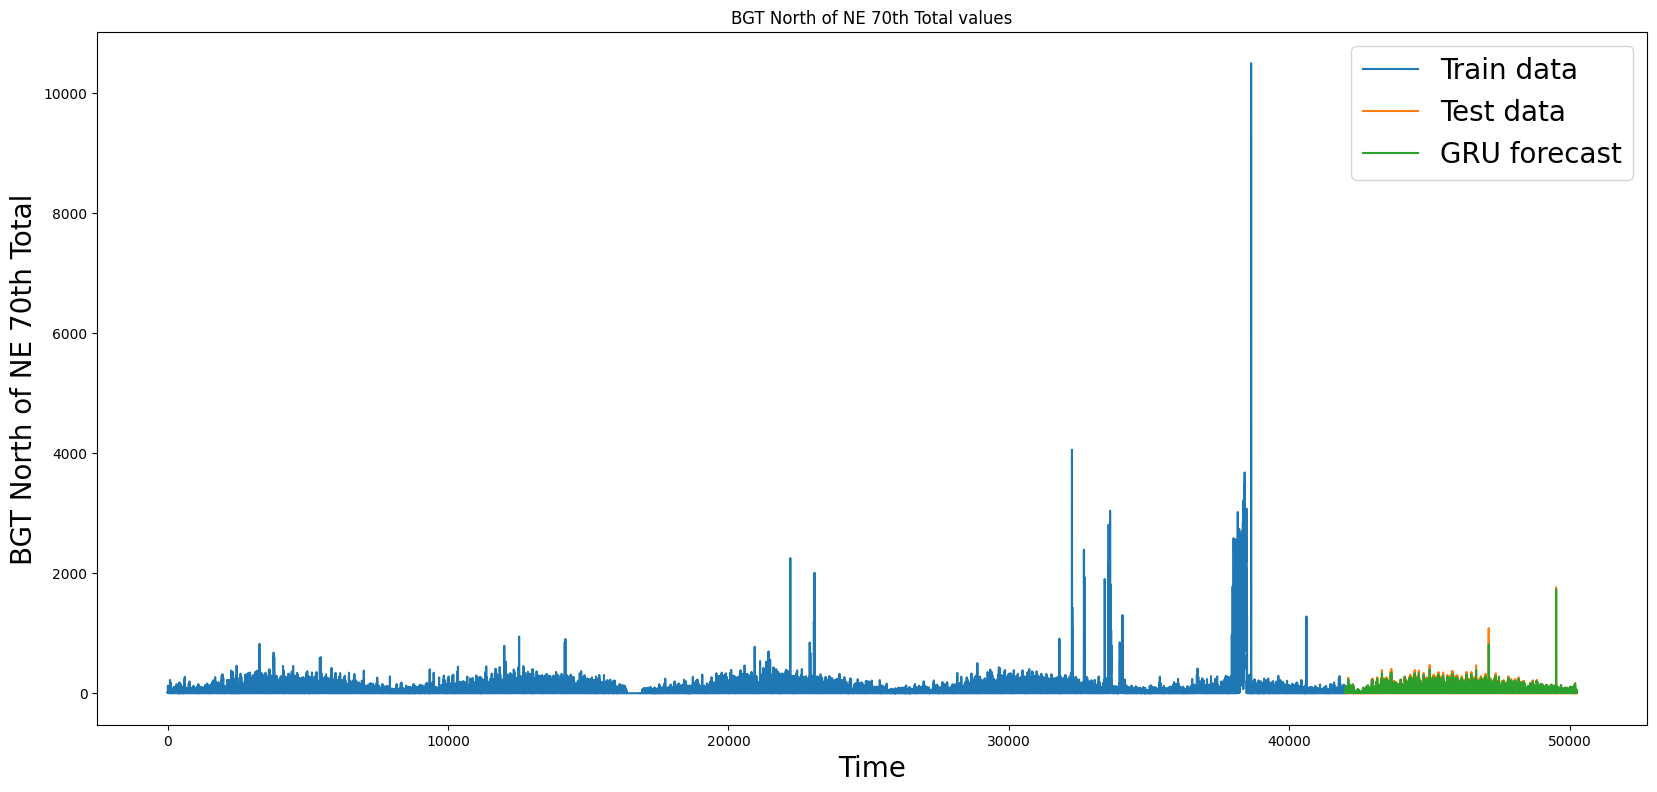

GRU Metrics BGT North of NE 70th Total:
RMSE: 38.84138047559708
MSE: 1508.6528372500939
SMAPE: 0.192
MAE: 20.044528345883645
R^2: 0.919085781328282


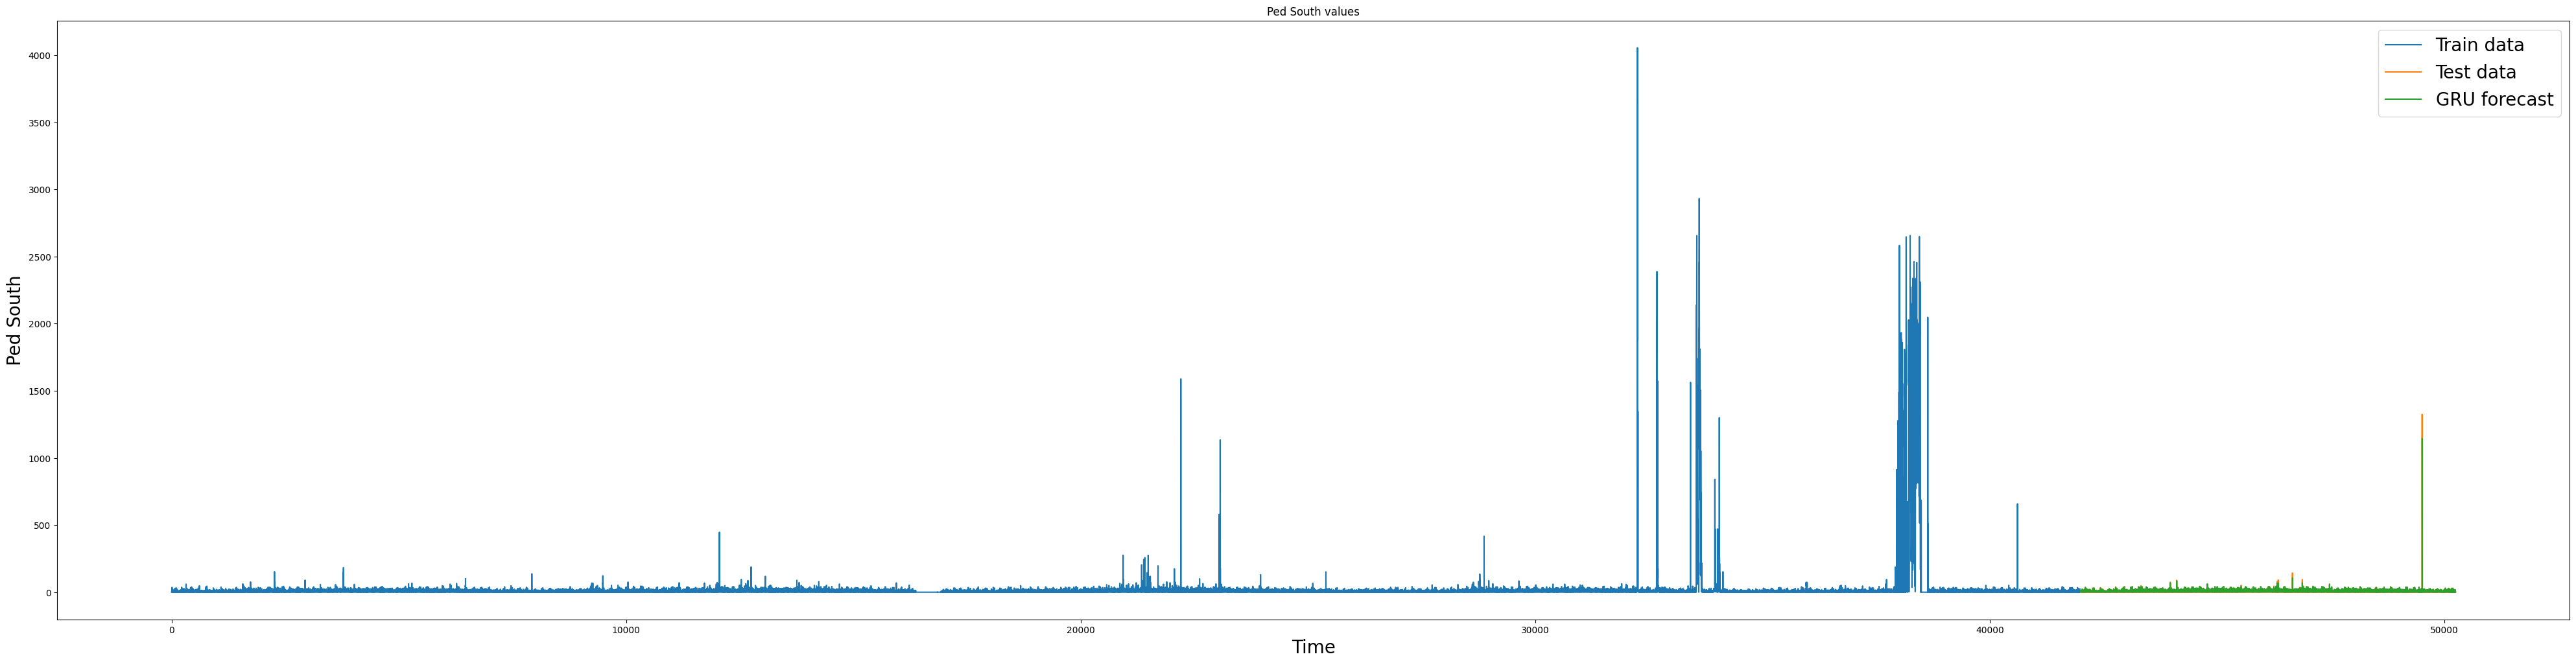

GRU Metrics Ped South:
RMSE: 19.16643706605228
MSE: 367.3523098069427
SMAPE: 0.235
MAE: 4.4081203338015325
R^2: 0.9595675335184456


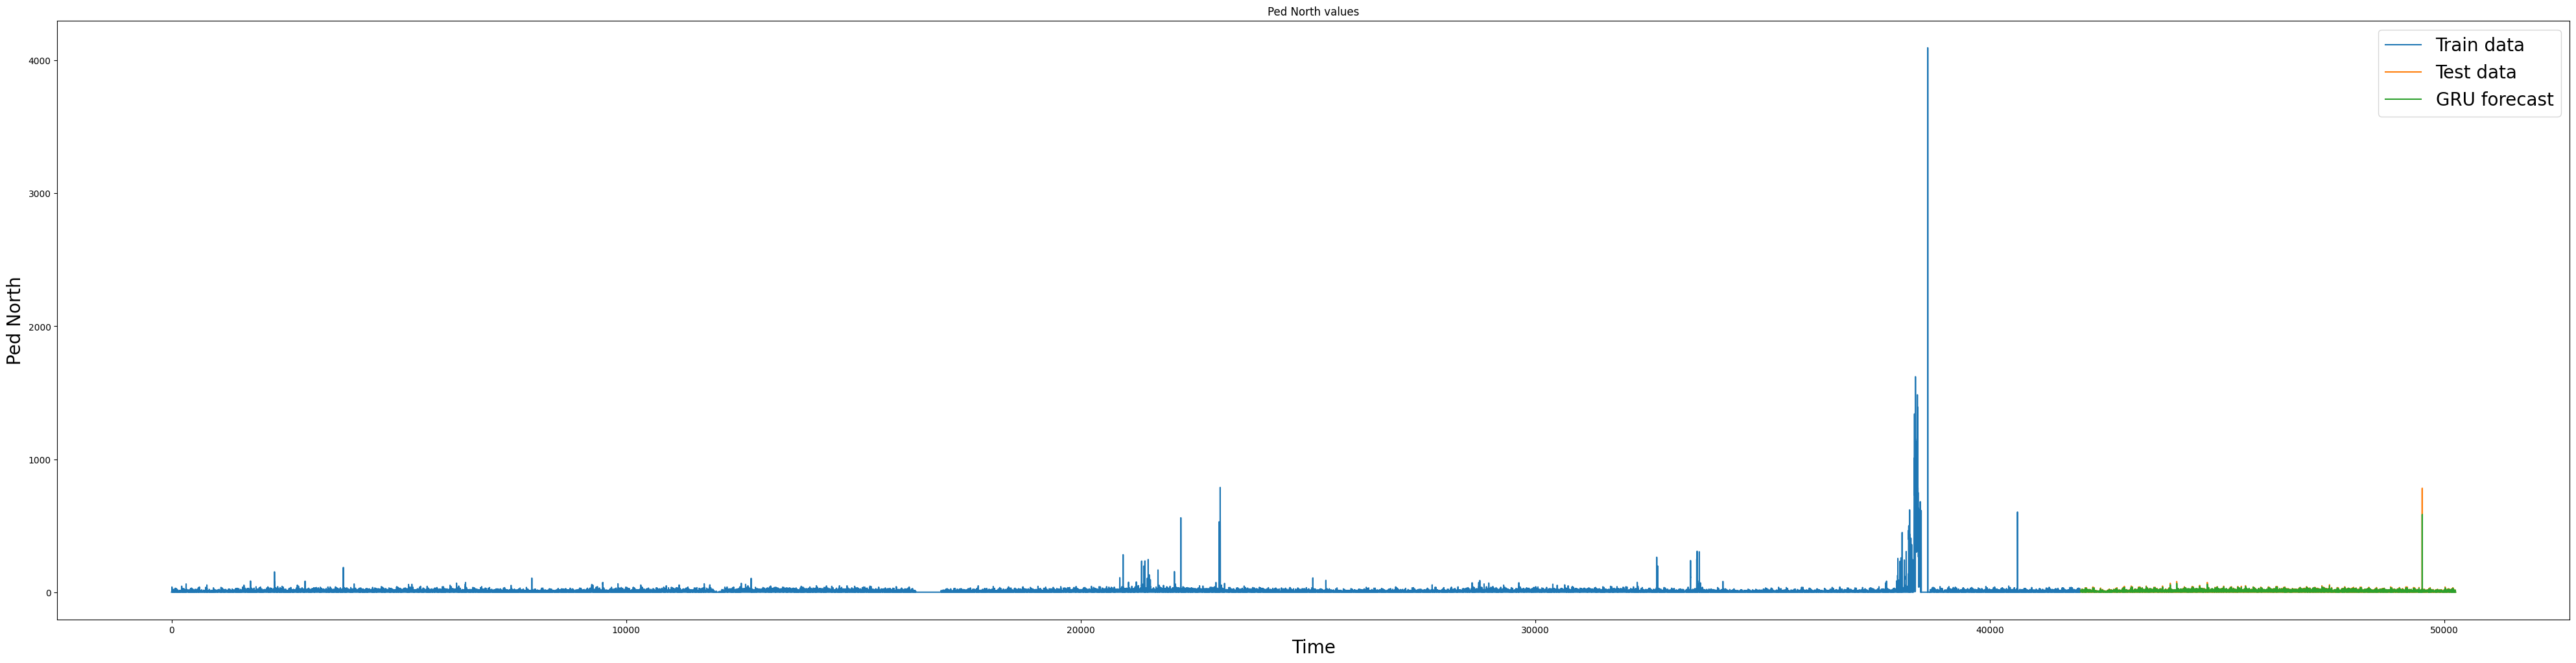

GRU Metrics Ped North:
RMSE: 9.646849405128837
MSE: 93.0617034452346
SMAPE: 0.228
MAE: 3.7884054202315416
R^2: 0.9818059987768558


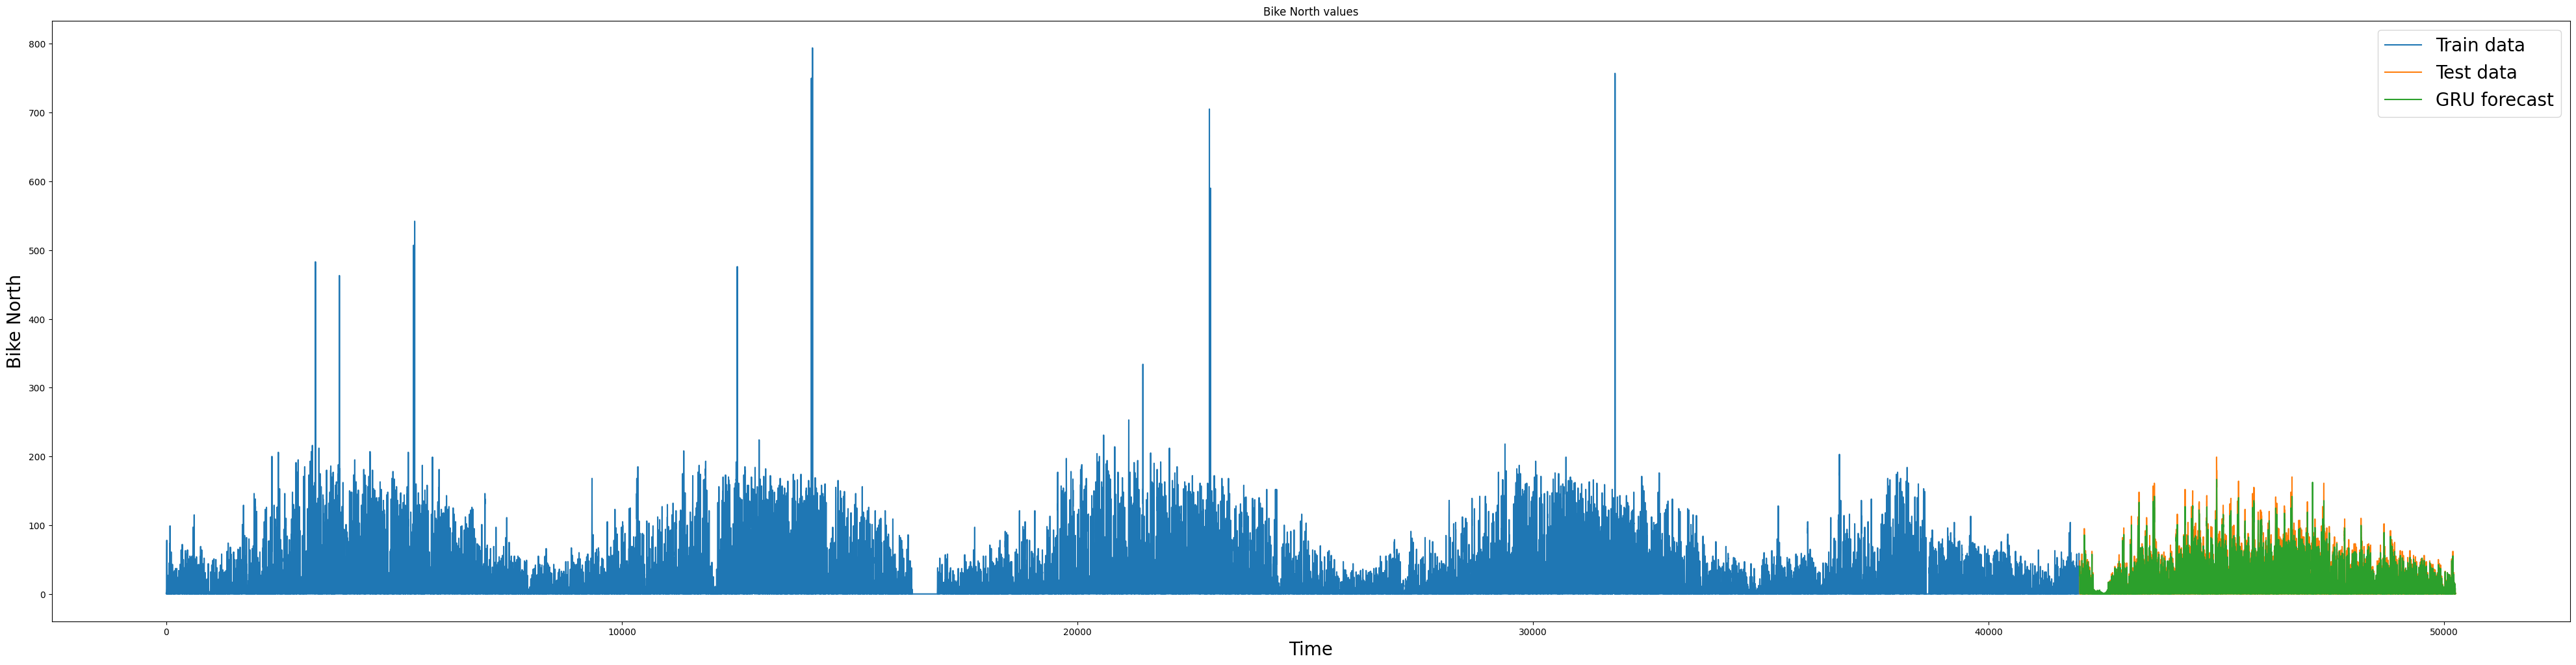

GRU Metrics Bike North:
RMSE: 12.328096605235073
MSE: 151.98196590800853
SMAPE: 0.24
MAE: 7.713855637968215
R^2: 0.9636567621246047


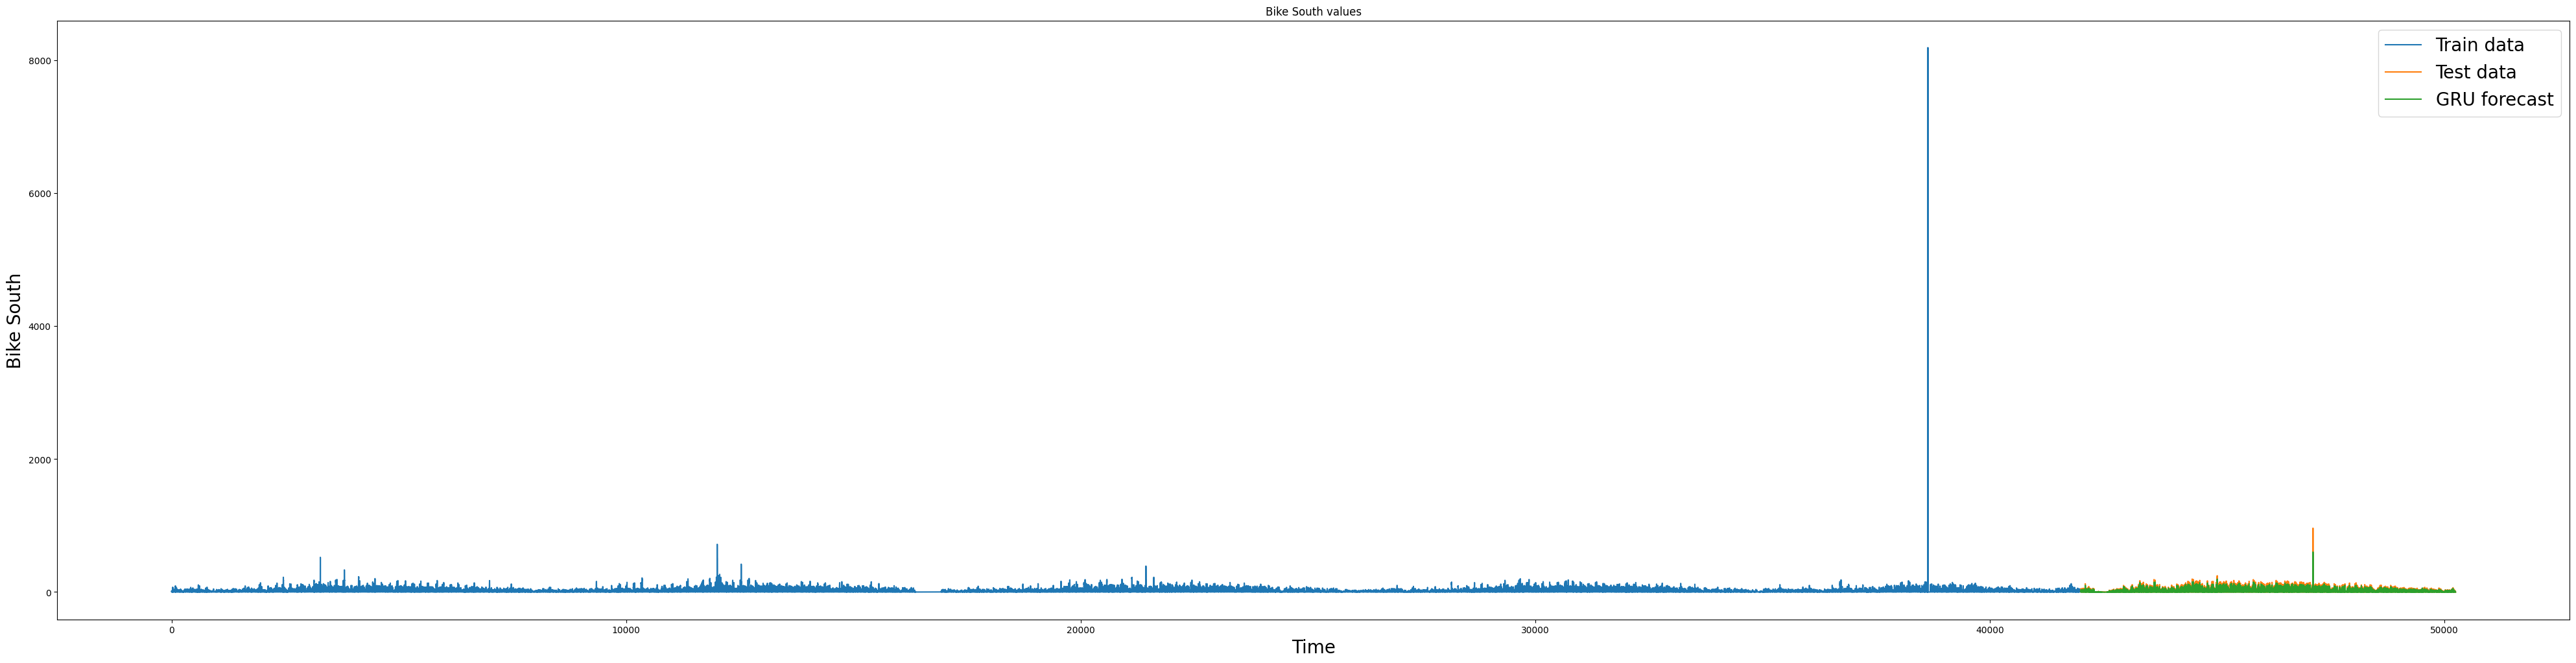

GRU Metrics Bike South:
RMSE: 19.096830526504423
MSE: 364.68893615803125
SMAPE: 0.269
MAE: 9.500662938495797
R^2: 0.9932925398470631


In [688]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = df.columns

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"GRU Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col)) 

In [557]:
data.columns

Index(['Date', 'BGT North of NE 70th Total', 'Ped South', 'Ped North',
       'Bike North', 'Bike South'],
      dtype='object')

In [689]:
df_tcn = pd.DataFrame(data['Date'])
df_tcn['BGT North of NE 70th Total'] = data['BGT North of NE 70th Total']
df_tcn['Ped South'] = data['Ped South']
df_tcn['Ped North'] = data['Ped North']
df_tcn['Bike North'] = data['Bike North']
df_tcn['Bike South'] = data['Bike South']
df_tcn.set_index('Date', inplace=True)

df_tcn.dropna(inplace=True)

lookback_window = 20

df_tcn = df_tcn.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

In [690]:
x_train = x[0:42000]
y_train = y[0:42000]
x_test = x[42000:]
y_test = y[42000:]

In [693]:
i = Input(shape=(lookback_window, 5))
m = TCN()(i)
m = Dense(5, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 tcn_5 (TCN)                 (None, 64)                137280    
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 137605 (537.52 KB)
Trainable params: 137605 (537.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [694]:
model.fit(x_train, y_train, epochs=10, verbose=0)

In [695]:
y_pred = model.predict(x_test)

258/258 [==============================] - 4s 13ms/step


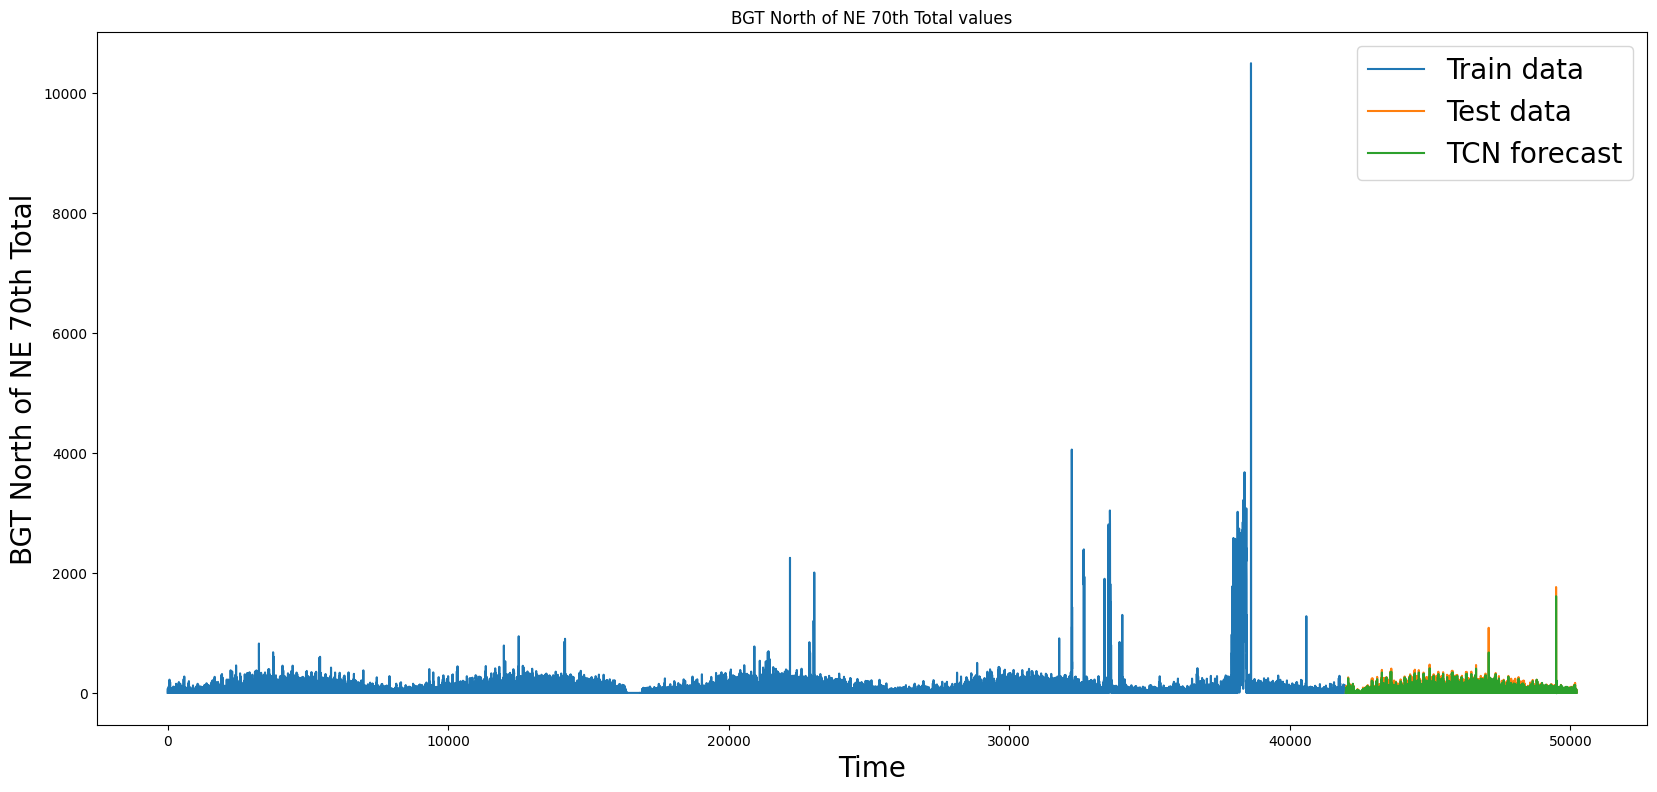

TCN Metrics BGT North of NE 70th Total:
RMSE: 34.69938313133685
MSE: 1204.0471896953045
SMAPE: 0.161
MAE: 14.45282764838589
R^2: 0.9917632719026576


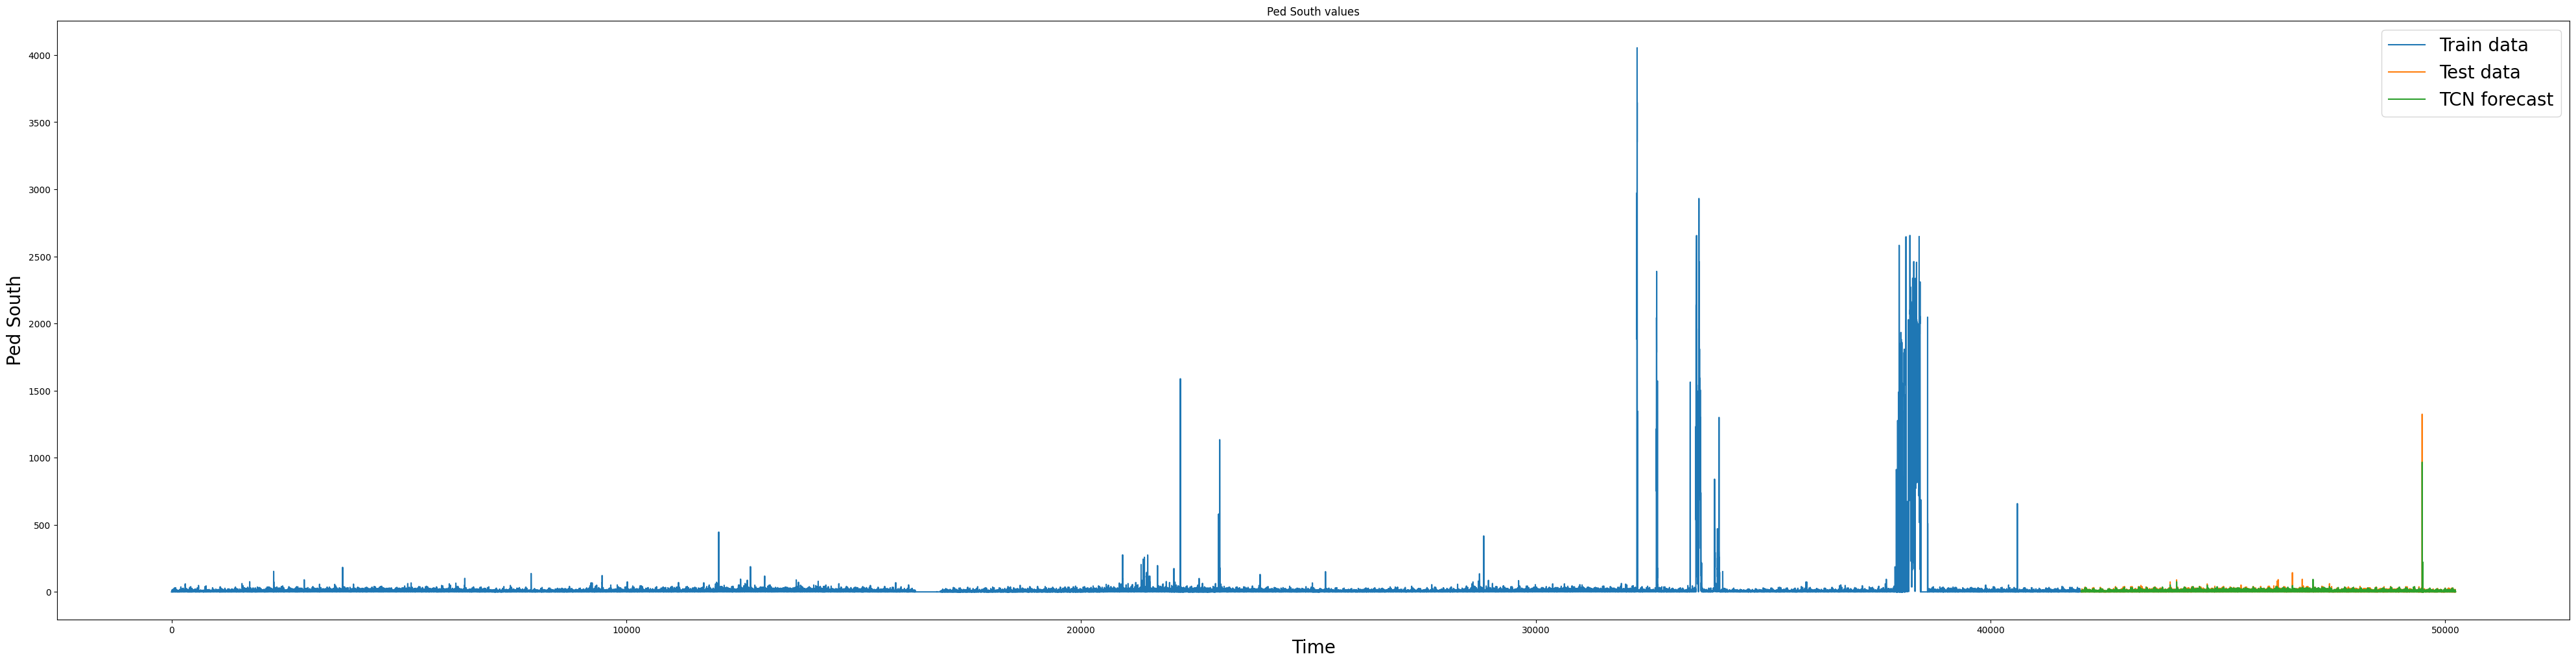

TCN Metrics Ped South:
RMSE: 18.999417758196643
MSE: 360.9778751504779
SMAPE: 0.248
MAE: 3.4089699311039077
R^2: 0.9825149854751807


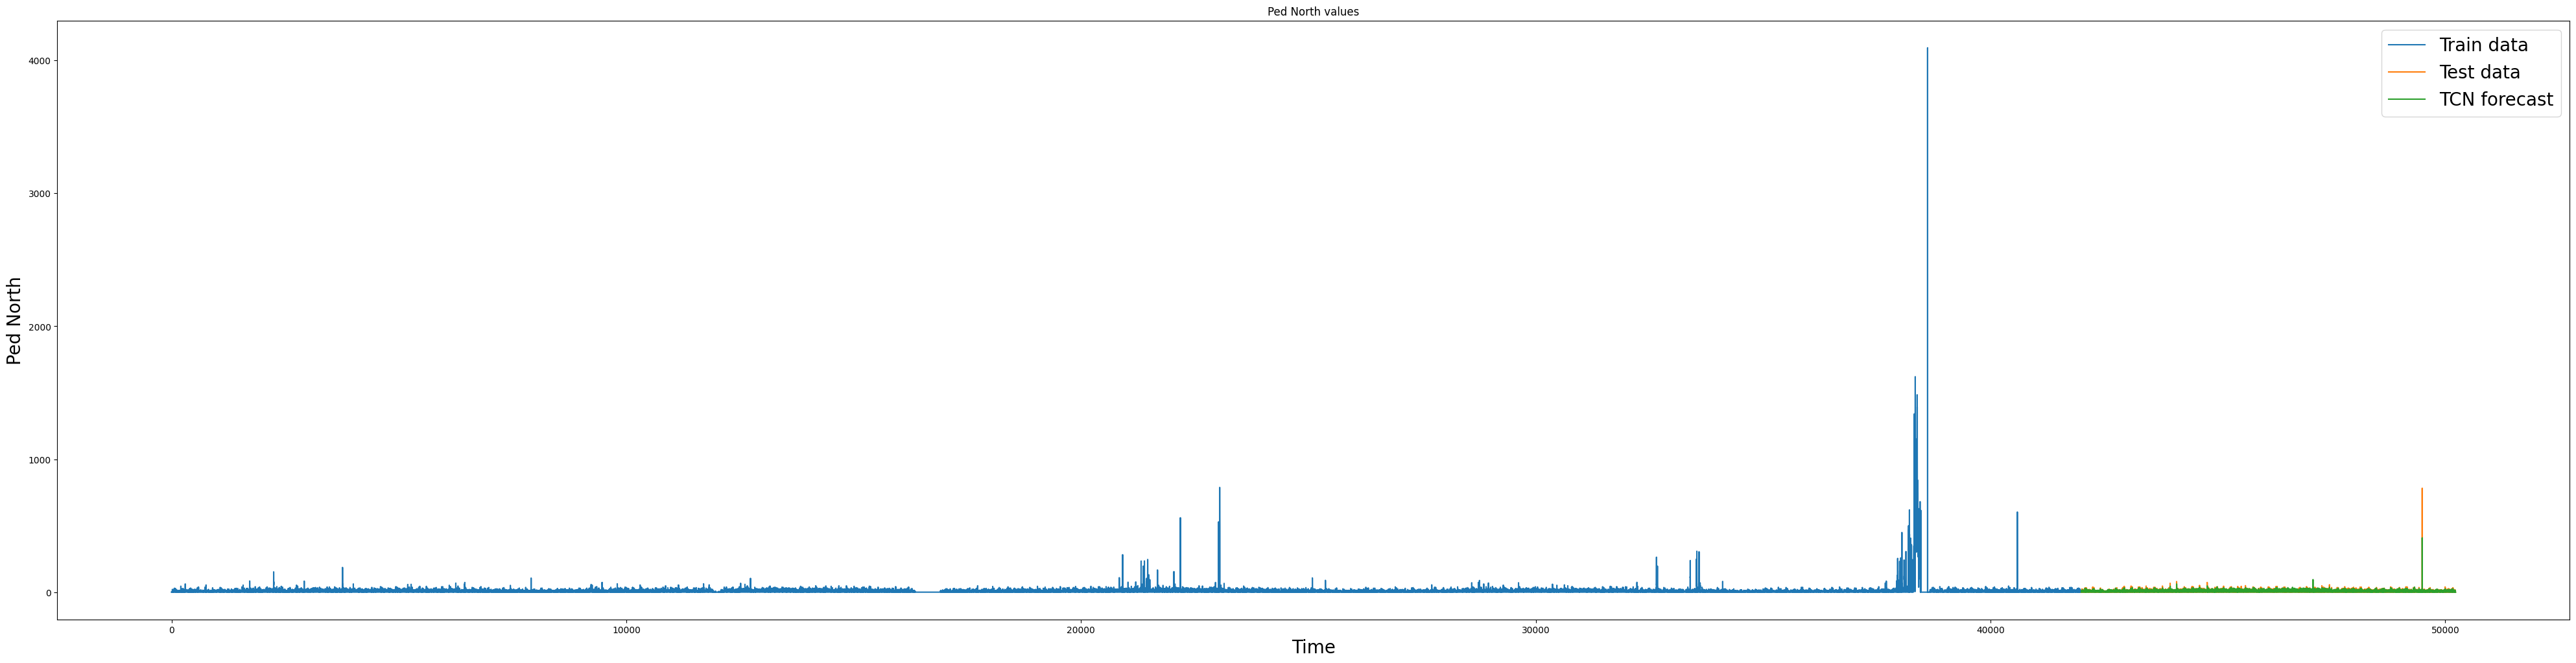

TCN Metrics Ped North:
RMSE: 8.088803996510979
MSE: 65.428750093972
SMAPE: 0.232
MAE: 3.0040843131912265
R^2: 0.9755636638305375


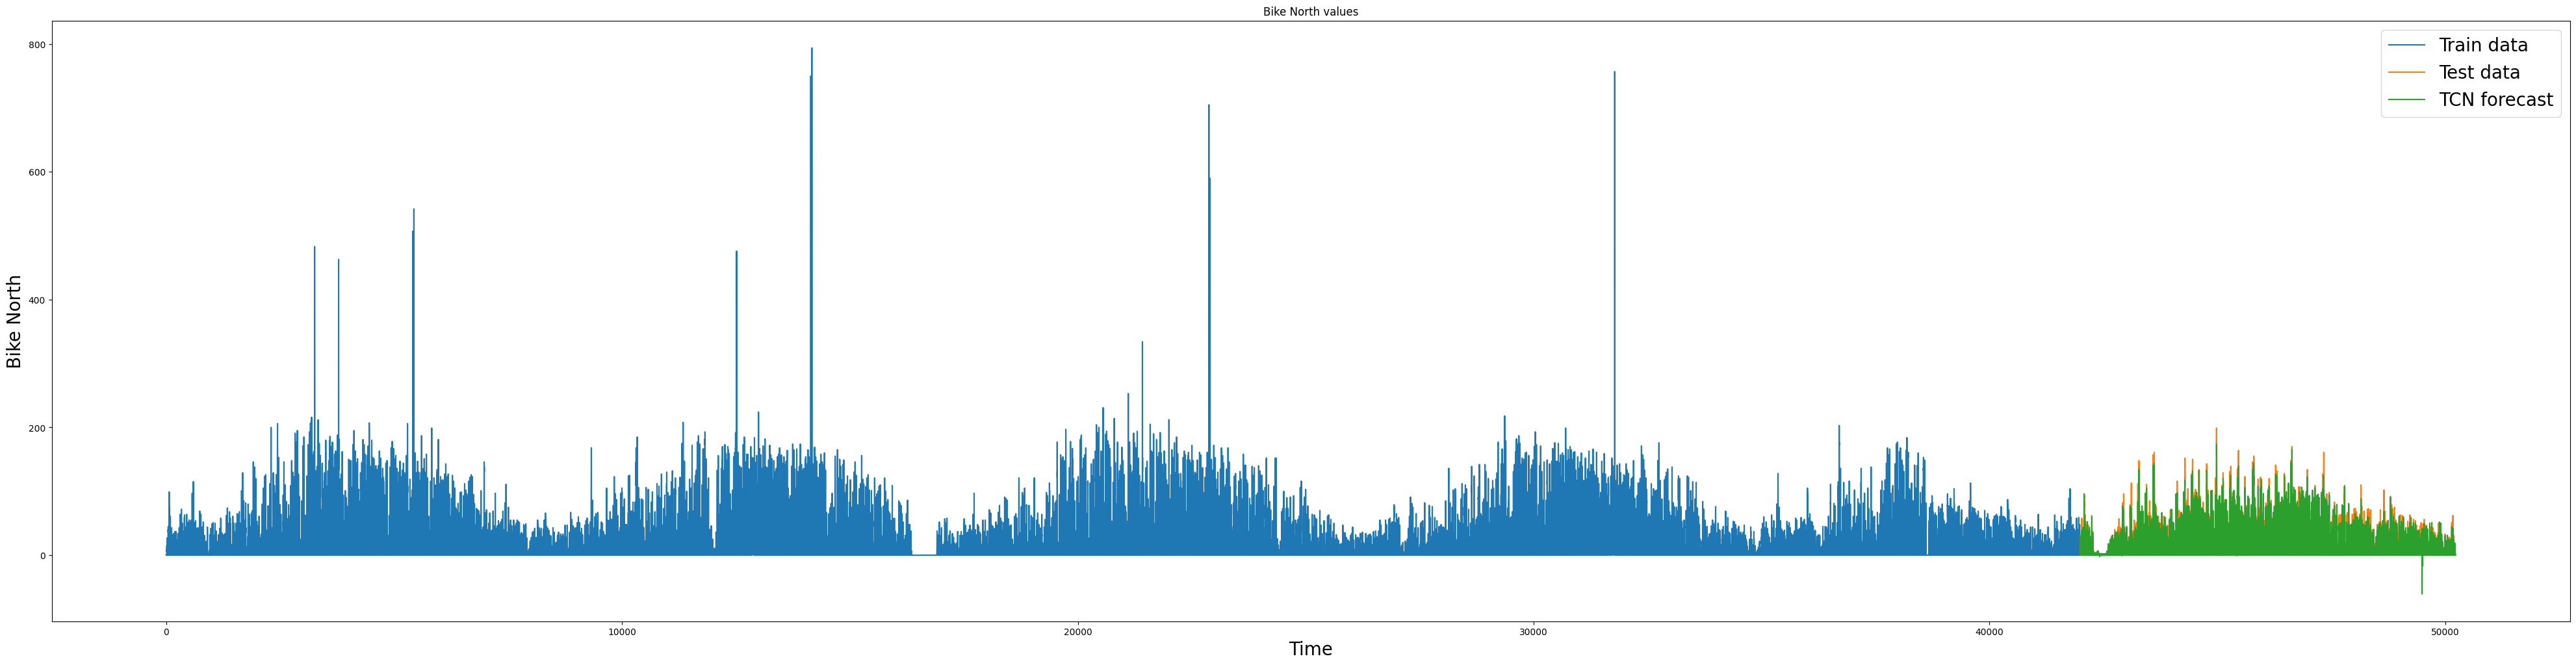

TCN Metrics Bike North:
RMSE: 9.566651825296423
MSE: 91.5208271464474
SMAPE: 0.22
MAE: 5.666541969388459
R^2: 0.9362931480440913


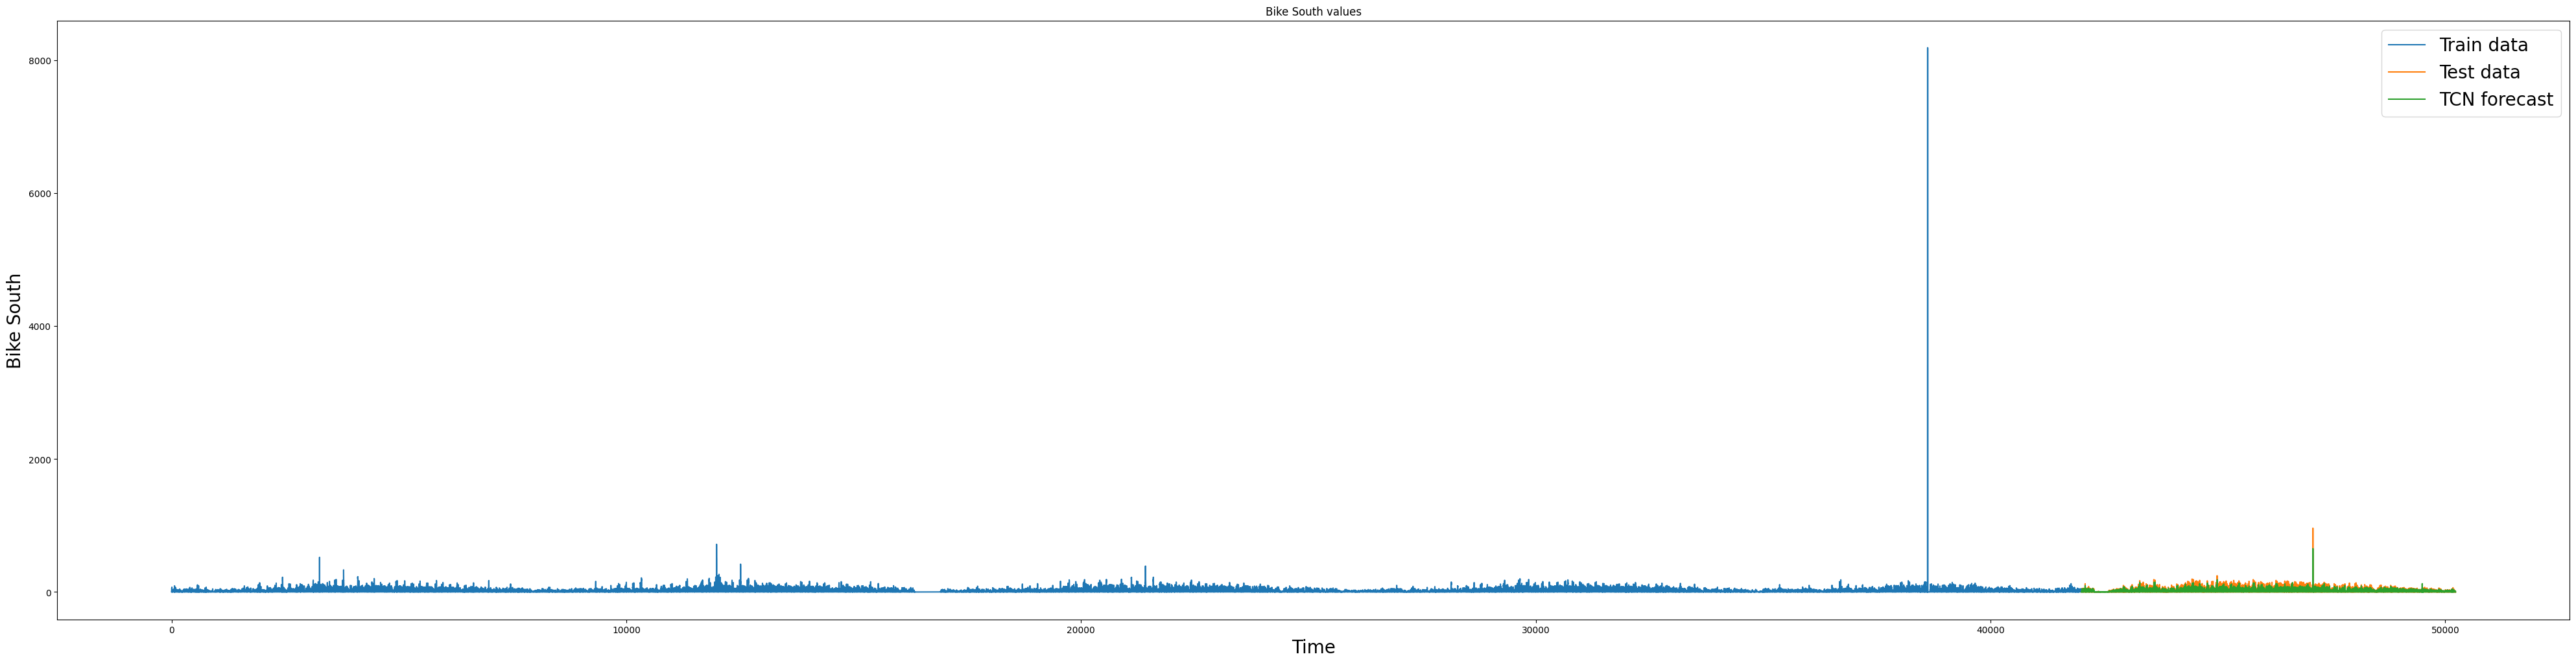

TCN Metrics Bike South:
RMSE: 17.76441445055117
MSE: 315.5744207709511
SMAPE: 0.221
MAE: 7.37036125004918
R^2: 0.9476722264225832


In [696]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = df.columns

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"TCN Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col)) 

Выводы:
Нейросети показали себя намного лучше классических моделей. Из классических моделей VARMAX лучше, чем VARMA. 
TCN учится дольше всех, но показывает те же результаты.